In [1]:
import numpy as np
import pandas as pd 
import warnings
import pickle
import scipy


import matplotlib.pyplot as plt
# import option_pricing as pricing

import scipy.stats as stats

from scipy.stats import norm, lognorm, t
from numpy.random import default_rng

from pandas.plotting import autocorrelation_plot
from scipy.stats import norm, probplot
from scipy.optimize import minimize

from tools_qfb import compare_histogram_pdf, qqplot
from my_time_series import (
    simulate_AR,
    residuals_AR,
    fit_AR_LS,
    fit_AR_ML_gaussian_noise,
    fit_AR_ML_student_t_noise,
    simulate_ARMA_GARCH,
    residuals_ARMA_GARCH, 
    fit_AR_GARCH_ML_gaussian_noise,
    fit_AR_GARCH_ML_student_t_noise,
    tests_gaussian_white_noise, 
    t_transient,
    test_t_student_noise,
    fit_AR_GARCH_ML_student_t_noise,
    arma_garch_t_noise,
    f_test
)
from trajectories import fancy_plot

from model_calibration import fit_pdf_ML
from datetime import datetime
from datetime import timedelta

eps_vol = lambda nu: np.sqrt(nu / (nu - 2)) ## vol = sqrt(h) * vol

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/ignacio/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/ignacio/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
def index_from_str_to_dt(df, date_type: str):
    dates = df.index.values
    new_dates = np.empty_like(dates)

    for i,date in enumerate(dates):
        try:
            new_dates[i] = datetime.strptime(date, f'{date_type}/%Y')
            continue
        except ValueError:
            pass
        
        try:
            new_dates[i] = datetime.strptime(date, f'{date_type}/%y')
            continue
        except ValueError:
            pass

        warnings.warn(f'Non accepted format in {date}')
        break
        

    df['Datetime'] = new_dates
    df = df.set_index('Datetime')
    
    return df

In [3]:
###### Data Cleaning ######


data = pd.read_csv('Data/data.csv',index_col='Date')
data = data.iloc[1501:, :]
data = data.rename(columns= {"Index1": "PJM_swap_1m",
#                             "Index2" :  ,
#                             "Index3" : ,
#                             "Index4" : 
                            })
data = data.drop(['Index2', 'Index3', 'Index4'], axis = 1)


data_get_fut_1m = pd.read_csv('data_christina/German Power Baseload Calendar Month Futures Historical Data(1)-3.csv')
data_get_fut_1m = data_get_fut_1m.rename(columns={'Price': 'ger_fut_1m'})
data_get_fut_1m = data_get_fut_1m[['ger_fut_1m', 'Date']]
# data_get_fut_1m['ger_fut_1m'] = data_get_fut_1m['ger_fut_1m'] / 24 

data_us_fut_1m = pd.read_csv('data_christina/PJM Western Hub Real-Time Off-Peak Calendar-Month 5 MW Futures Historical Data.csv')
data_us_fut_1m = data_us_fut_1m.rename(columns={'Price': 'us_fut_1m'})
data_us_fut_1m = data_us_fut_1m[['us_fut_1m', 'Date']]
# data_us_fut_1m['us_fut_1m'] = data_us_fut_1m['us_fut_1m'] / 5

data_gas = pd.read_csv('Data/data_gas.csv', index_col = 'Date')
data_gas = data_gas.iloc[::-1]
data_gas = data_gas.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
data_gas = data_gas.rename(columns = {'Price': 'Gas_EU'})

data_sp = pd.read_csv('Data/data_sp.csv', index_col = 'Date')
data_sp = data_sp.iloc[::-1]
data_sp = data_sp.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
data_sp = data_sp.rename(columns={"Price": "SP500"})
data_sp["SP500"] = data_sp["SP500"].str.replace(',', '')
data_sp["SP500"] = pd.to_numeric(data_sp["SP500"])

data_ger_f = pd.read_csv('Data/data_ger_futures.csv',index_col = 'Date')
data_ger_f = data_ger_f.rename(columns = {'Value 1m': 'Ger_fw_1m' })

data_ger_1y = pd.read_csv('Data/data_ger_1y.csv',index_col = 'Date')
data_ger_1y = data_ger_1y.rename(columns = {'Value 1Y': 'Ger_fw_1y'})

data_gas_us = pd.read_csv('Data/data_gas_us.csv', index_col = 'Date')
data_gas_us = data_gas_us.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
data_gas_us = data_gas_us.rename(columns={"Price": "Gas_US"})
data_gas_us['Gas_US'] = data_gas_us['Gas_US'] * 10000 / 2930

data_ep_tx = pd.read_csv('Data/day_ahead_houston.csv')
data_ep_tx = data_ep_tx[data_ep_tx.zone == 'LZ_HOUSTON']
data_ep_tx = data_ep_tx.drop(['zone'], axis = 1)
data_ep_tx['Date'] = data_ep_tx['Date'].apply(lambda x: x.split(' ')[0])
data_ep_tx = data_ep_tx.groupby('Date').mean()
data_ep_tx = data_ep_tx.rename(columns={"price": "Tx_1d"})

data_ep_was = pd.read_csv('Data/day_ahead_was.csv')
data_ep_was = data_ep_was[data_ep_was.node_name == 'PEPCO ZONE']
data_ep_was = data_ep_was.drop(['node_name'], axis = 1)
data_ep_was['Date'] = data_ep_was['Date'].apply(lambda x: x.split(' ')[0])
data_ep_was = data_ep_was.groupby('Date').mean()
data_ep_was = data_ep_was.rename(columns={"total_lmp": "Was_1d"})

data_eex_qt = pd.read_csv('Data/eex_data_qt.csv')
data_eex_qt['Exchange Date'] = data_eex_qt['Exchange Date'].apply(lambda x: x.replace('-','/'))
data_eex_qt = data_eex_qt.set_index(data_eex_qt['Exchange Date'])
data_eex_qt = data_eex_qt.drop(['Exchange Date'], axis = 1)
data_eex_qt = data_eex_qt.rename(columns={"Close": "eex_qt"})


data            = index_from_str_to_dt(data       , '%d/%m')
data_gas        = index_from_str_to_dt(data_gas   , '%m/%d')
data_sp         = index_from_str_to_dt(data_sp    , '%m/%d')
data_ger_f      = index_from_str_to_dt(data_ger_f , '%d/%m')
data_ger_1y     = index_from_str_to_dt(data_ger_1y, '%m/%d')
data_gas_us     = index_from_str_to_dt(data_gas_us, '%m/%d')
data_ep_tx      = index_from_str_to_dt(data_ep_tx , '%m/%d')
data_ep_was     = index_from_str_to_dt(data_ep_was, '%m/%d')
data_eex_qt     = index_from_str_to_dt(data_eex_qt, '%d/%b')
data_get_fut_1m = index_from_str_to_dt(data_get_fut_1m.set_index('Date')  , '%m/%d')
data_us_fut_1m  = index_from_str_to_dt(data_us_fut_1m.set_index('Date')   , '%m/%d')


data = pd.merge(data, data_gas       , left_index=True, right_index=True)
data = pd.merge(data, data_sp        , left_index=True, right_index=True)
data = pd.merge(data, data_ger_f     , left_index=True, right_index=True)
data = pd.merge(data, data_ger_1y    , left_index=True, right_index=True)
data = pd.merge(data, data_gas_us    , left_index=True, right_index=True)
data = pd.merge(data, data_ep_tx     , left_index=True, right_index=True)
data = pd.merge(data, data_ep_was    , left_index=True, right_index=True)
data = pd.merge(data, data_eex_qt    , left_index=True, right_index=True)
data = pd.merge(data, data_get_fut_1m, left_index=True, right_index=True)
data = pd.merge(data, data_us_fut_1m , left_index=True, right_index=True)


date_f = pd.to_datetime(pd.DataFrame(data.index.values,columns=['col1']).col1).dt.to_period('m')

data_eu = pd.read_csv('Data/dayahead_europa.csv', delimiter=';')
data_eu['datetime'] = data_eu['datetime'].apply(lambda x:x[:10])

data_esp = data_eu[data_eu['name'] == 'Marginal price Day Ahead market Spain']
data_esp = data_esp.copy()
data_esp['datetime'] = data_esp['datetime'].apply(lambda x: x.replace('-', '/'))
data_esp['datetime'] = data_esp['datetime'].apply(lambda x: x[5:] + '/' + x[:4])
data_esp = data_esp.set_index(data_esp['datetime'])
data_esp = data_esp.drop(['name', 'id', 'geoid', 'geoname', 'datetime'], axis = 1)
data_esp = data_esp.rename(columns={"value": "spa_1d"})


data_ger = data_eu[data_eu['name'] == 'Marginal price Day Ahead market Germany']
data_ger = data_ger.copy()
data_ger['datetime'] = data_ger['datetime'].apply(lambda x: x.replace('-', '/'))
data_ger['datetime'] = data_ger['datetime'].apply(lambda x: x[5:] + '/' + x[:4])
data_ger = data_ger.set_index(data_ger['datetime'])
data_ger = data_ger.drop(['name', 'id', 'geoid', 'geoname', 'datetime'], axis = 1)
data_ger = data_ger.rename(columns={"value": "ger_1d"})


data_fr = data_eu[data_eu['name'] == 'Marginal price Day Ahead market France']
data_fr = data_fr.copy()
data_fr['datetime'] = data_fr['datetime'].apply(lambda x: x.replace('-', '/'))
data_fr['datetime'] = data_fr['datetime'].apply(lambda x: x[5:] + '/' + x[:4])
data_fr = data_fr.set_index(data_fr['datetime'])
data_fr = data_fr.drop(['name', 'id', 'geoid', 'geoname', 'datetime'], axis = 1)
data_fr = data_fr.rename(columns={"value": "fr_1d"})


data_esp = index_from_str_to_dt(data_esp , '%m/%d')
data_ger = index_from_str_to_dt(data_ger , '%m/%d')
data_fr  = index_from_str_to_dt(data_fr  , '%m/%d')

data_eu = pd.merge(data_esp, data_ger   , left_index=True, right_index=True)
data_eu = pd.merge(data_eu , data_fr    , left_index=True, right_index=True)

# us_fut = pd.read_csv('Data/data_fut_us.csv')
# us_fut['Exchange Date'] = us_fut['Exchange Date'].apply(lambda x: x.replace('-','/'))
# us_fut = us_fut.set_index(us_fut['Exchange Date'])
# us_fut = us_fut.drop(['Exchange Date'], axis = 1)
# us_fut = us_fut.rename(columns={"Close": "us_fut"})

# us_fut = index_from_str_to_dt(us_fut, '%d/%b')
# us_fut = us_fut.sort_index()
# us_fut['us_fut'] = us_fut['us_fut'].fillna(method='ffill')

data_fut_gas = pd.read_csv('Data/futures_eu_us_gas.csv')
data_fut_gas['date'] = data_fut_gas['date'].apply(lambda x: x.replace('-','/'))
data_fut_gas = data_fut_gas.set_index(data_fut_gas['date'])
data_fut_gas = data_fut_gas.drop(['date','us_vol', 'eu_vol'], axis = 1)
data_fut_gas = index_from_str_to_dt(data_fut_gas , '%d/%m')
data_fut_gas['us_fut'] = data_fut_gas['us_fut'] * 10000 / 2930
data_fut_gas = data_fut_gas.rename(columns={"us_fut": "us_fut_gas", "eu_fut": "eu_fut_gas"})

all_data = pd.merge(data_eu , data   , left_index=True, right_index=True)
# all_data = pd.merge(all_data, us_fut , left_index=True, right_index=True)

data_garch = data[['Gas_EU', 'Gas_US', 'eex_qt', 'ger_fut_1m', 'us_fut_1m']]
data_garch = pd.merge(data_garch, data_fut_gas,left_index=True,right_index=True)

###### Exchange rate ######

fx_eu_per_usd = pd.read_csv('data_christina/fx_usd_eur.csv')
fx_eu_per_usd = fx_eu_per_usd[['Date', 'Close']].iloc[1:,:] ## Dropping first row to match time series with utilities
fx_eu_per_usd = fx_eu_per_usd.rename(columns = {'Close': 'fx'})
fx_eu_per_usd['Date'] = fx_eu_per_usd.Date.apply(lambda date: datetime.strptime(date, f'%Y-%m-%d'))
fx_eu_per_usd = fx_eu_per_usd.set_index('Date')

european_variables = ['spa_1d', 'get_1d', 'fr_1d', 'Gas_EU', 'Ger_fw_1m', 'Ger_fw_1y', 'eex_qt', 'eu_fut_gas', 'ger_fut_1m' ]
datasets           = [all_data, data, data_garch]

for dataset in datasets:
    for variable in european_variables:
        if variable not in dataset.keys():
            continue
        dataset[variable] = dataset[variable].div(fx_eu_per_usd.loc[dataset.index.values,'fx'],axis = 0)
        
crisis_thershold = np.datetime64('2021-08-01')
start_thershold  = np.datetime64('2020-01-01')

all_data   = all_data
data_garch = data_garch[start_thershold:]
data       = data[start_thershold:]

In [4]:
np.log(all_data['Gas_EU']).diff()[:crisis_thershold].mean()*252

1.4398226333873279

In [11]:
np.log(all_data['Gas_EU']).diff()[crisis_thershold:].mean()*252

0.8606593444107434

In [10]:
data_garch['us_fut_1m']

Datetime
2018-08-28    26.25
2018-08-29    26.85
2018-08-30    27.15
2018-08-31    27.15
2018-09-04    27.20
              ...  
2022-11-22    84.25
2022-11-25    89.85
2022-11-28    81.75
2022-11-29    83.45
2022-11-30    81.25
Name: us_fut_1m, Length: 1015, dtype: float64

### Garch fitting

In [17]:
crisis_thershold = np.datetime64('2021-08-01')
start_thershold  = np.datetime64('2020-01-01')

In [12]:
data_garch.

Index(['Gas_EU', 'Gas_US', 'eex_qt', 'ger_fut_1m', 'us_fut_1m', 'us_fut_gas',
       'eu_fut_gas'],
      dtype='object')

In [14]:
data_garch

Gas_EU     Gas_US      eex_qt  ger_fut_1m  us_fut_1m  \
Datetime                                                               
2018-08-28   29.629630   9.733788   67.484519   65.743662      26.25   
2018-08-29   30.245283   9.880546   68.288634   65.669792      26.85   
2018-08-30   30.597548   9.808874   70.539468   65.797023      27.15   
2018-08-31   30.135660   9.952218   69.346429   69.183124      27.15   
2018-09-04   31.024950   9.634812   67.985411   66.684477      27.20   
...                ...        ...         ...         ...        ...   
2022-11-22  122.579455  23.136519  366.652323  168.797771      84.25   
2022-11-25  129.445560  23.972696  367.697416  175.511818      89.85   
2022-11-28  127.810896  22.907850  353.895599  179.783319      81.75   
2022-11-29  136.857025  24.692833  376.608732  179.629630      83.45   
2022-11-30  151.145503  23.651877  396.109729  325.861838      81.25   

            us_fut_gas  eu_fut_gas  
Datetime                            
2018-08-28    9.761092   29.676364  
2018-08-29    9.774744   30.490799  
2018-08-30    9.839590   30.386773  
2018-08-31    9.969283   30.368953  
2018-09-04    9.604096   31.106258  
...                ...         ...  
2022-11-22   23.590444  127.558861  
2022-11-25   23.215017  130.205352  
2022-11-28   23.163823  127.157742  
2022-11-29   24.825939  133.716118  
2022-11-30   23.791809  150.737685  

[1015 rows x 7 columns]

In [264]:
results['us_fut_1m'][0]

[0.38604282777627297,
 array([0.0955956]),
 0.551919105554326,
 array([0.05705184]),
 array([0.82889527]),
 2.907873903585173]

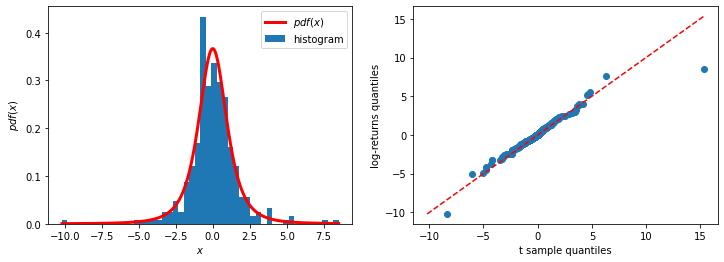

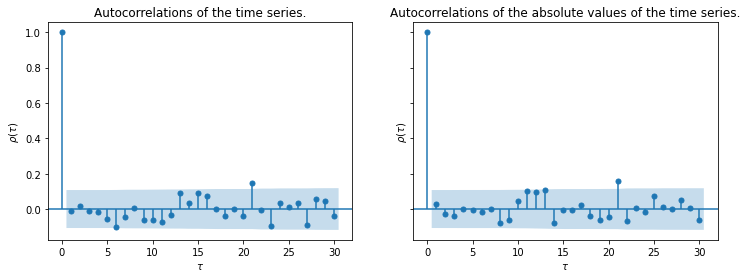

In [265]:
nu_ML = results['us_fut_1m'][0][-1]
u = results['us_fut_1m'][1]
h = results['us_fut_1m'][2]

test_t_student_noise(u/np.sqrt(h), nu_ML)

/home/ignacio/Documents/ICADE/paper_christina/my_time_series.py:450: RuntimeWarning: invalid value encountered in sqrt
  t.logpdf(u, df = df, loc = 0.0, scale = np.sqrt(h))


Maximum likelihood estimates:
0.4564 [0.1068] 6.1321 [0.1336] [0.6844] 7.5444



/home/ignacio/Documents/ICADE/paper_christina/my_time_series.py:450: RuntimeWarning: invalid value encountered in sqrt
  t.logpdf(u, df = df, loc = 0.0, scale = np.sqrt(h))


Maximum likelihood estimates:
0.3346 [-0.0964] 1.7192 [0.0641] [0.8392] 10.426

Maximum likelihood estimates:
0.275 [0.1425] 2.5876 [0.1151] [0.7149] 4.2288

Maximum likelihood estimates:
-0.1779 [0.1142] 0.4191 [0.0514] [0.6916] 1.5558

Maximum likelihood estimates:
0.386 [0.0956] 0.5519 [0.0571] [0.8289] 2.9079

Maximum likelihood estimates:
0.3654 [-0.0636] 2.7006 [0.0689] [0.7382] 5.8709



/home/ignacio/Documents/ICADE/paper_christina/my_time_series.py:450: RuntimeWarning: invalid value encountered in sqrt
  t.logpdf(u, df = df, loc = 0.0, scale = np.sqrt(h))


Maximum likelihood estimates:
0.4516 [0.0495] 6.8151 [0.1833] [0.6353] 9.0932



/home/ignacio/Documents/ICADE/paper_christina/my_time_series.py:546: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)


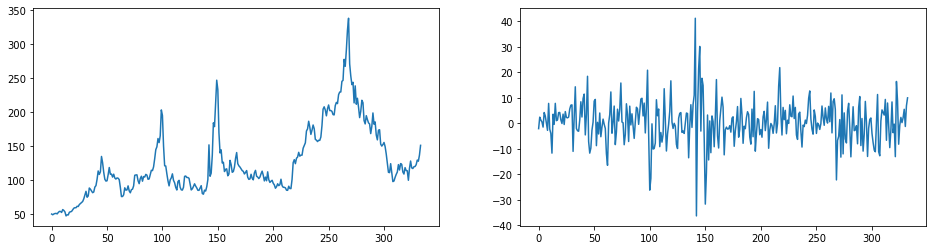

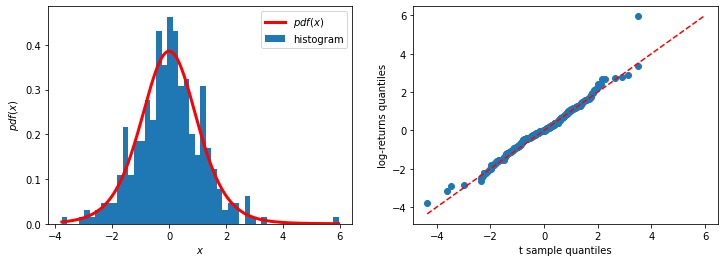

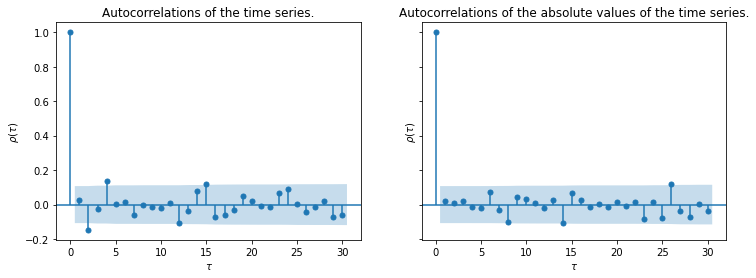

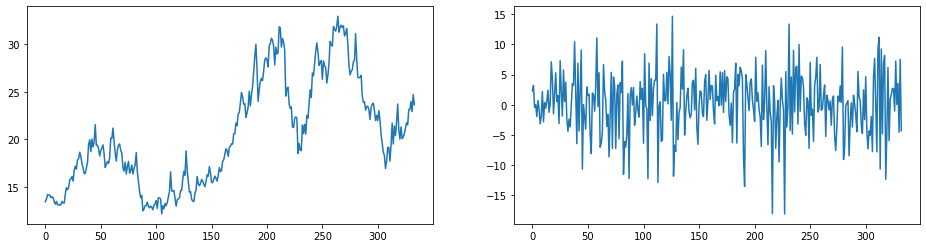

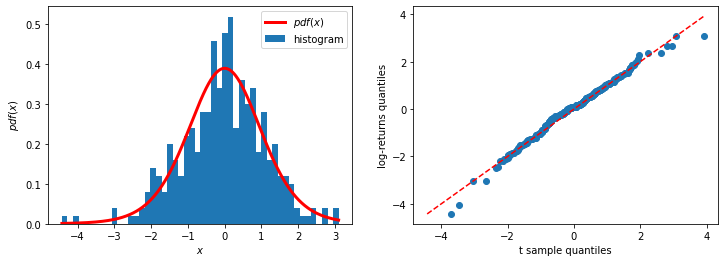

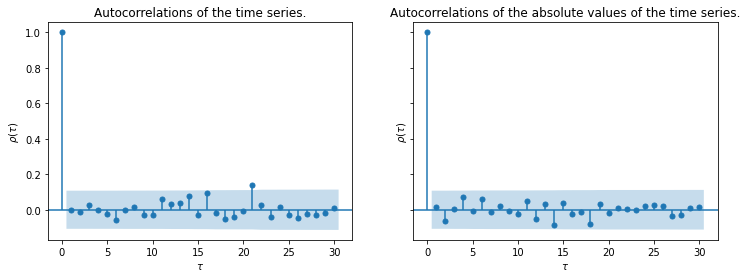

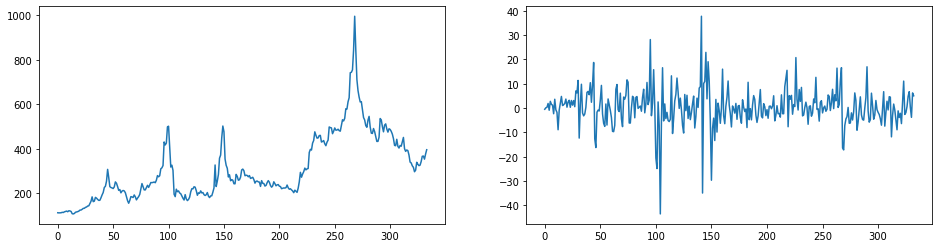

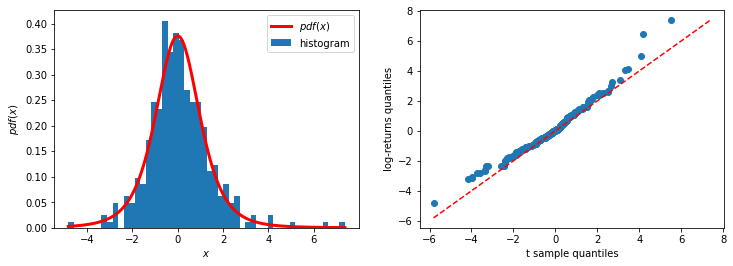

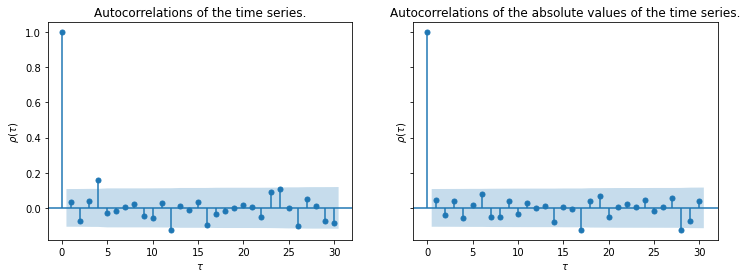

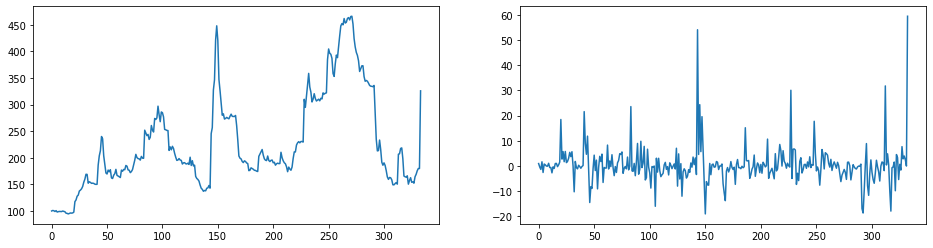

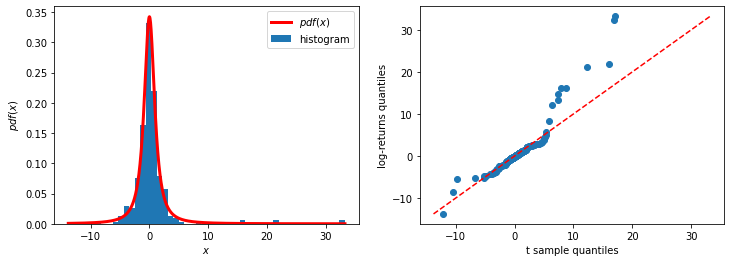

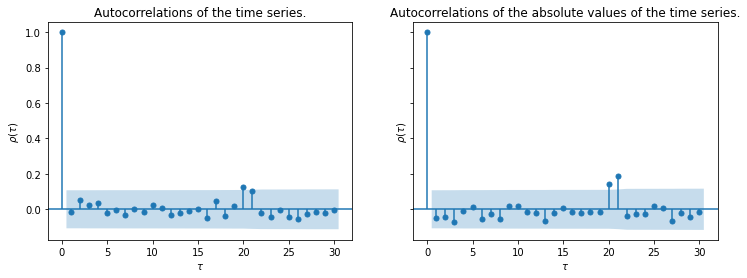

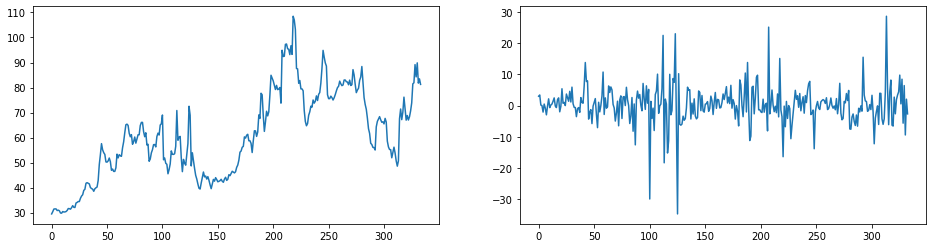

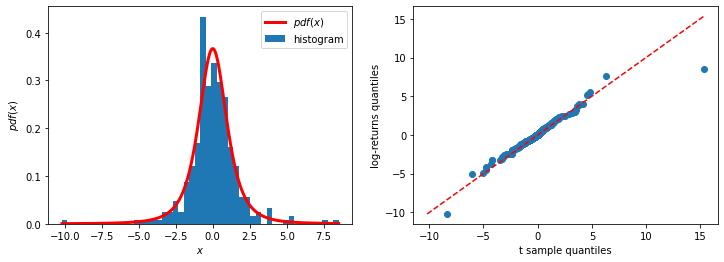

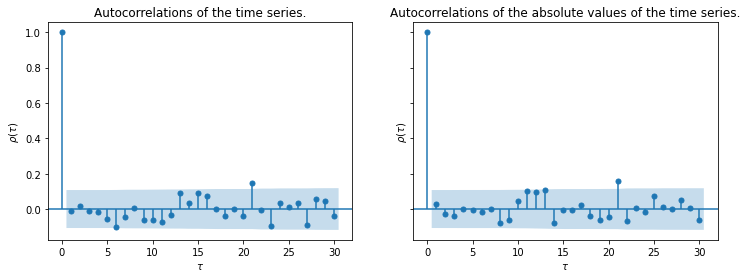

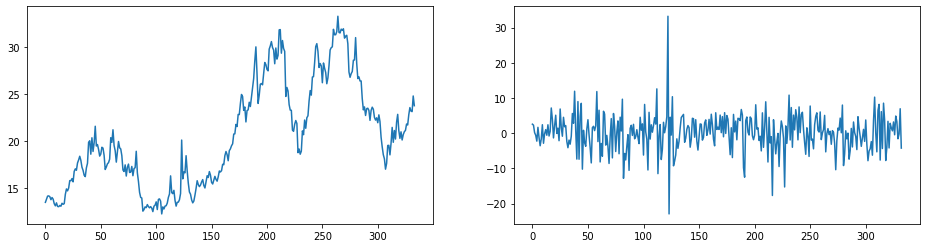

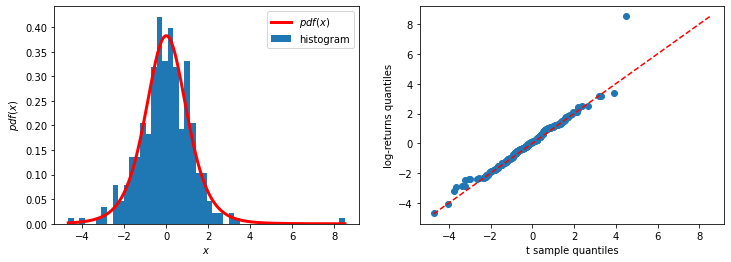

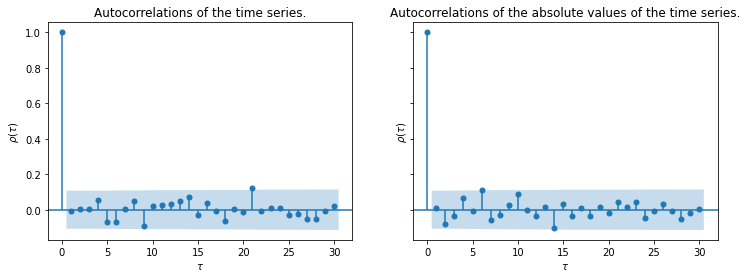

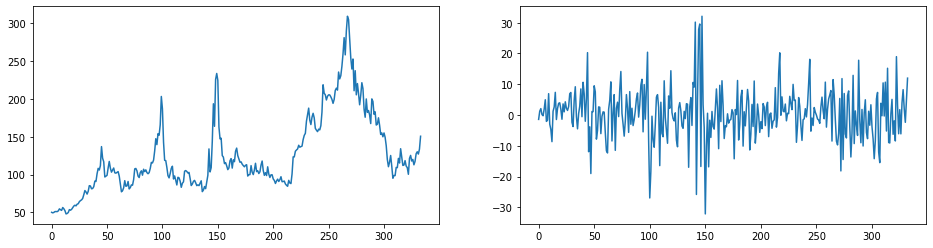

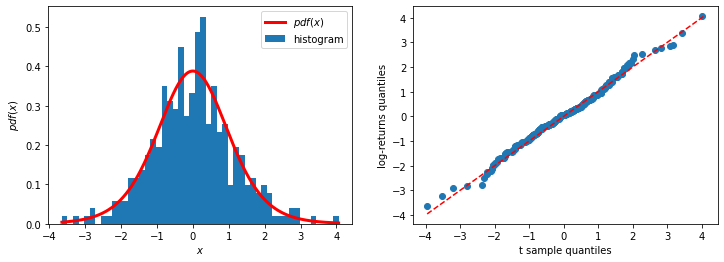

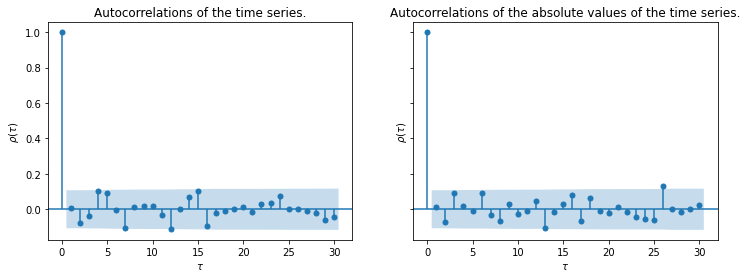

In [20]:
## For the US FUTURES we only use the last part of the sample because in the early part the value is almost constant thus the returns are mostly 0 and the fit is impossible.

pre_squeeze = False
results = {}

for key in data_garch.keys():    
    
    if pre_squeeze:
        prices = data_garch[key][start_thershold:crisis_thershold].values
    else:
        prices = data_garch[key][crisis_thershold:].values
            
    phi_0, phi= 0.2, [0.1]
    theta = []
    kappa = 0.1
    alpha = [0.05]
    beta = [0.90]
    p = len(phi)
    q = len(theta)
    r = len(alpha) 
    s = len(beta)
    delay = max(p, q, r, s)
    nu = 5
    
    params, u, h = arma_garch_t_noise(prices,phi_0, phi, theta, kappa, alpha, beta, nu)
    
    results[key] = [params, u , h]
    

if pre_squeeze:
    with open('fitted_models_pre_crisis.pickle', 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
     with open('fitted_models_crisis.pickle', 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### First plots and tables

In [15]:
data_garch

PJM_swap_1m     Gas_EU    Gas_US      eex_qt   Ger_fw_1m  \
Datetime                                                               
2020-01-03        34.10  14.506111  7.269625   40.943316   44.909176   
2020-01-06        34.45  13.706887  7.286689   40.294676   43.866503   
2020-01-07        34.50  13.359208  7.378840   40.212000   43.560201   
2020-01-08        34.50  13.346645  7.307167   40.056666   43.224612   
2020-01-09        32.75  13.535890  7.392491   40.218708   43.285954   
...                 ...        ...       ...         ...         ...   
2023-01-30        62.52  59.962602  9.320819  150.884937  140.513568   
2023-01-31        62.52  62.228733  9.354949  159.711372  155.164931   
2023-02-01        39.95  64.649789  8.655290  163.609310  152.867833   
2023-02-02        42.14  62.817308  8.607509  158.287722  147.021574   
2023-02-03        38.61  63.129771  8.464164  158.647764  154.034896   

             Ger_fw_1y  us_fut  us_fut_gas  eu_fut_gas  
Datetime                                                
2020-01-03   50.718323    30.0    7.215017   14.578725  
2020-01-06   49.614912    30.0    7.334471   13.701306  
2020-01-07   50.111028    30.0    7.351536   13.381604  
2020-01-08   49.527039    30.0    7.341297   13.385686  
2020-01-09   50.065012    30.0    7.392491   13.335852  
...                ...     ...         ...         ...  
2023-01-30  185.901896    59.0    9.174061   60.336580  
2023-01-31  190.972222    59.0    9.290102   62.230903  
2023-02-01  201.470572    58.0    8.539249   63.210713  
2023-02-02  192.724910    59.0    8.368601   62.580531  
2023-02-03  195.201745    58.0    8.139932   63.904035  

[769 rows x 9 columns]

In [16]:
rolling_delay = 30
date_f = pd.to_datetime(pd.DataFrame(data_garch.index.values,columns=['col1']).col1).dt.to_period('m')

for ploting, name in enumerate(['Figures/levels.pdf', 'Figures/levels_bands.pdf', 'Figures/returns_bands.pdf']):
    for serie in ['eu_fut_gas', 'us_fut_gas', 'Gas_EU', 'Gas_US']:
        u  = results[serie][1]
        h  = results[serie][2]
        df = results[serie][0][-1]
        x  = range(len(h))

        prices = data_garch[serie].values
        x = range(len(prices) - 1)
        labels = data_garch[serie].index.values

        innovation_top = t.ppf(0.95, df = df, scale = np.sqrt(h) )
        innovation_bot = t.ppf(0.05, df = df, scale = np.sqrt(h) )

        prices_top = prices[:-1] * np.exp(innovation_top / 100)
        prices_bot = prices[:-1] * np.exp(innovation_bot / 100)
        
    
        plt.xticks(x, date_f[1:], rotation = 70)
        plt.locator_params(axis='x', nbins=9)
    
        if serie == 'eu_fut_gas':
            label = 'EU gas future'
        if serie == 'us_fut_gas':
            label = 'US gas future'
        if serie == 'Gas_EU':
            label = 'EU gas spot'
        if serie == 'Gas_US':
            label = 'US gas spot'

        if ploting == 0:
            plt.plot(x, prices[1:], label = label)
        
        if ploting == 1:
            plt.fill_between(x, prices_top, prices_bot, where= prices_top >= prices_bot, interpolate=True, alpha = 0.8, label = f'{label} IQR')
            
        if serie == 'Gas_EU':
            continue
        if serie == 'Gas_US':
            continue
            
        if ploting == 2:
            plt.fill_between(x, innovation_top, innovation_bot, where= innovation_top >= innovation_bot, interpolate=True, alpha = 0.8, label = f'{label} IQR')
    
    plt.axvline(x = 410, color = 'red', linestyle="--", label = 'Gas Crisis')
    plt.legend()
    plt.tight_layout()
    plt.savefig(name)
    plt.show()


KeyError: 'eu_fut_gas'

[]

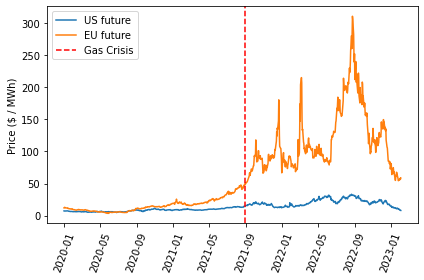

In [11]:
first_jan = data_fut_gas.index.values[351]
thirtyone_aug = data_fut_gas.index.values[785]

plt.plot(data_fut_gas['us_fut_gas'][first_jan:],label = 'US future')
plt.plot(data_fut_gas['eu_fut_gas'][first_jan:],label = 'EU future')
plt.xticks(rotation = 70)
plt.axvline(x = thirtyone_aug, color = 'red', linestyle="--", label = 'Gas Crisis')
plt.legend()
plt.ylabel('Price ($ / MWh)')
plt.tight_layout()
plt.savefig('Figures/month_gas_comp.pdf')
plt.plot()

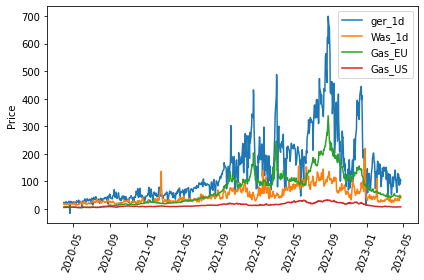

In [17]:
variables = ['ger_1d', 'Was_1d', 'Gas_EU', 'Gas_US']

for var in variables:
    std_data = (all_data[var] - np.mean(all_data[var])) / np.std(all_data[var])
    plt.plot(all_data[var], label = var)
    
plt.xticks(rotation = 70)
plt.legend()
plt.ylabel('Price')
plt.tight_layout()
plt.savefig('Figures/ger_vs_was_vs_gas_vs_gas.pdf')
plt.show()

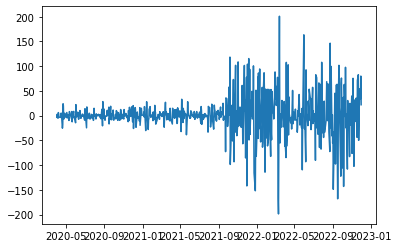

/home/ignacio/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


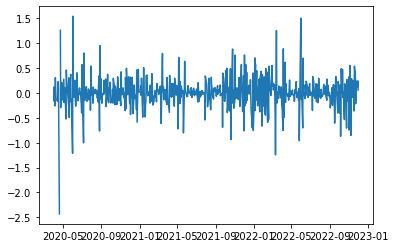

In [222]:
plt.plot(all_data['ger_1d'].diff())
plt.show()
plt.plot((np.log(all_data['ger_1d'])).diff())
plt.show()

In [235]:
(np.log(all_data['ger_1d'])).diff()[:330].replace(np.nan,0)

Datetime
2020-04-01    0.000000
2020-04-02   -0.157748
2020-04-03    0.121665
2020-04-06   -0.262226
2020-04-07    0.305932
                ...   
2021-07-29   -0.544027
2021-07-30    0.340646
2021-08-02    0.211844
2021-08-03    0.186412
2021-08-04    0.017041
Name: ger_1d, Length: 330, dtype: float64

In [236]:
f_test((np.log(all_data['ger_1d'])).diff()[:330].replace(np.nan,0), (np.log(all_data['ger_1d'])).diff()[330:680].replace(np.nan,0))

/home/ignacio/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(0.8877501142360306, 0.8596355006106371)

In [245]:
F_stats

[('spa_1d', 0.9999998613184506),
 ('ger_1d', 0.14680575749293212),
 ('fr_1d', 0.3480525683413741),
 ('PJM_swap_1m', 1.1102230246251565e-16),
 ('Gas_EU', 1.1102230246251565e-16),
 ('SP500', 0.0022037038388998953),
 ('Ger_fw_1m', 1.1102230246251565e-16),
 ('Ger_fw_1y', 1.1102230246251565e-16),
 ('Gas_US', 6.649585782003697e-08),
 ('Tx_1d', 1.0),
 ('Was_1d', 0.0007890423980517758),
 ('eex_qt', 1.1102230246251565e-16),
 ('ger_fut_1m', 1.1102230246251565e-16),
 ('us_fut_1m', 1.1102230246251565e-16)]

In [251]:
log_data       = all_data.diff()
log_diff       = (np.log(all_data)).diff()

F_stats = []
for key in log_diff.keys():
    x = log_diff[key][1:330].replace(np.nan,0)
    y = log_diff[key][330:680].replace(np.nan,0)
    F_stats.append(f_test(y,x)[1])

log_summ_stats_pos = log_diff[330:680].agg([ "mean","std", "median"]).transpose()
log_summ_stats_pre = log_diff[:330].agg([ "mean","std", "median"]).transpose()

log_summ_stats_pos['mean'] = log_summ_stats_pos['mean']  * 252
log_summ_stats_pos['median']  = log_summ_stats_pos['median'] * 252
log_summ_stats_pos['std']  = log_summ_stats_pos['std']   * np.sqrt(252)
log_summ_stats_pos['F_statistic'] = np.array(F_stats)/100

log_summ_stats_pre['mean'] = log_summ_stats_pre['mean']  * 252
log_summ_stats_pre['median']  = log_summ_stats_pre['median'] * 252
log_summ_stats_pre['std']  = log_summ_stats_pre['std']   * np.sqrt(252)

print(log_summ_stats_pre.apply(lambda x: np.round(x*100,2)).to_latex())
print(log_summ_stats_pos.apply(lambda x: np.round(x*100,2)).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &    mean &     std &  median \\
\midrule
spa\_1d      &  112.14 &  382.20 &  230.05 \\
ger\_1d      &   20.38 &  471.21 &  -80.33 \\
fr\_1d       &  111.59 &  322.01 &  -55.07 \\
PJM\_swap\_1m &   61.98 &   77.99 &    0.00 \\
Gas\_EU      &  145.29 &   73.98 &  185.61 \\
SP500       &   44.26 &   18.68 &   44.87 \\
Ger\_fw\_1m   &  126.46 &   64.52 &   43.97 \\
Ger\_fw\_1y   &   66.71 &   27.79 &   57.96 \\
Gas\_US      &   73.78 &   60.68 &   42.58 \\
Tx\_1d       &   74.99 &  756.22 & -322.67 \\
Was\_1d      &   63.83 &  246.79 &  109.57 \\
eex\_qt      &  102.59 &   46.41 &   36.43 \\
ger\_fut\_1m  &  135.41 &   64.77 &    9.83 \\
us\_fut\_1m   &   54.32 &   48.96 &    0.00 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
{} &    mean &     std &  median &  F\_statistic \\
\midrule
spa\_1d      &   17.05 &  287.25 &  206.01 &         1.00 \\
ger\_1d      &  106.06 &  497.82 &  112.67 &         0.15 \\
fr\_1d       &  101.21 &  329.03 &

/home/ignacio/miniconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
<ipython-input-251-344dafe46dd3>:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(log_summ_stats_pre.apply(lambda x: np.round(x*100,2)).to_latex())
<ipython-input-251-344dafe46dd3>:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(log_summ_stats_pos.apply(lambda x: np.round(x*100,2)).to

In [185]:
summ_stats = (np.log(all_data).diff()[330:]*252).agg([ "mean","std", "median"]).transpose()

/home/ignacio/miniconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [177]:
print(summ_stats.apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  mean &    std &  median \\
\midrule
spa\_1d      &  0.17 &  45.60 &    2.06 \\
ger\_1d      &  1.06 &  79.03 &    1.13 \\
fr\_1d       &  1.01 &  52.23 &    3.96 \\
PJM\_swap\_1m &  0.60 &  19.83 &    0.00 \\
Gas\_EU      &  0.84 &  20.68 &    1.11 \\
SP500       & -0.06 &   3.47 &   -0.13 \\
Ger\_fw\_1m   &  0.79 &  19.62 &    0.09 \\
Ger\_fw\_1y   &  1.10 &  14.82 &    1.93 \\
Gas\_US      &  0.39 &  12.92 &    1.10 \\
Tx\_1d       &  0.15 &  66.84 &    0.59 \\
Was\_1d      &  0.32 &  46.67 &    0.88 \\
eex\_qt      &  0.96 &  19.56 &    0.66 \\
ger\_fut\_1m  &  0.90 &  18.62 &   -0.73 \\
us\_fut\_1m   &  0.73 &  15.24 &    0.41 \\
\bottomrule
\end{tabular}



<ipython-input-177-d9d8f15f13e1>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summ_stats.apply(lambda x: np.round(x,2)).to_latex())


In [35]:
list(all_data.keys())

['spa_1d',
 'ger_1d',
 'fr_1d',
 'PJM_swap_1m',
 'Gas_EU',
 'SP500',
 'Ger_fw_1m',
 'Ger_fw_1y',
 'Gas_US',
 'Tx_1d',
 'Was_1d',
 'eex_qt',
 'us_fut']

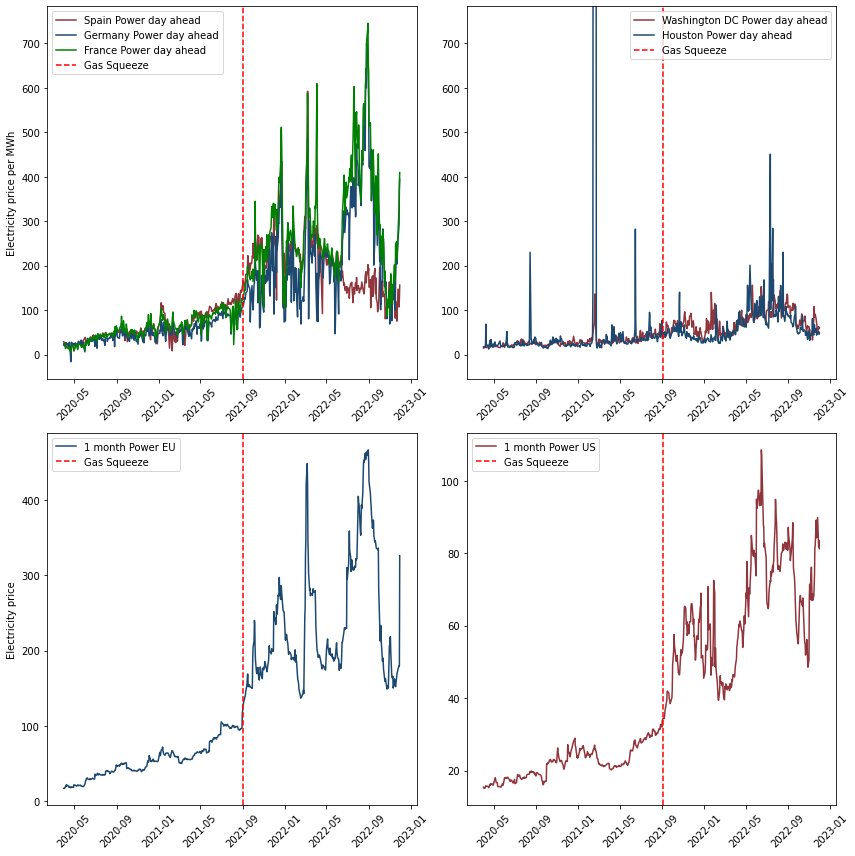

In [8]:
fig, ax = plt.subplots(2, 2,  figsize = (12, 12))

eu_vars = ['spa_1d', 'ger_1d', 'fr_1d']

us_vars = ['Was_1d', 'Tx_1d',]

fut_eu = ['eex_qt', 'ger_fut_1m']
fut_eu = ['ger_fut_1m']

fut_us = ['us_fut_1m']

gas_comp = ['Gas_EU', 'Gas_US' ]

colors = ['#90353b', '#1d4971', 'green']

gas_crisis = all_data.index.values[350]

xs = pd.to_datetime(pd.DataFrame(all_data.index.values,columns=['col1']).col1).dt.to_period('m')

ax3 = plt.subplot(224)
ax4 = plt.subplot(223)
ax2 = plt.subplot(222)
ax1 = plt.subplot(221)

i = 0
label_eu_1d = ['Spain Power day ahead', 'Germany Power day ahead', 'France Power day ahead']
for var in eu_vars:
    ax1.plot( all_data[var]  , label = label_eu_1d[i], color = colors[i])
    i+=1
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)

i=0
label_us_1d = ['Washington DC Power day ahead', 'Houston Power day ahead']
for var in us_vars:
    ax2.plot( all_data[var]  , label = label_us_1d[i], color = colors[i])
    i+=1
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)

i = 0
for var in fut_us:
    ax3.plot( all_data[var]  , label = '1 month Power US', color = colors[i])
    i+=1
    for tick in ax3.get_xticklabels():
        tick.set_rotation(45)

i = 0
labels_eu = ['3 month Power EU', '1 month Power EU']
labels_eu = ['1 month Power EU']

for var in fut_eu:
    ax4.plot( all_data[var]  , label = labels_eu[i], color = colors[i+1])
    i+=1
    for tick in ax4.get_xticklabels():
        tick.set_rotation(45)

                
        
ax1.axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Squeeze')
ax1.legend()   
ax3.axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Squeeze')
ax3.legend()  
ax2.axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Squeeze')
ax2.legend()   
ax4.axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Squeeze')
ax4.legend()   


# ax[2,0].set_ylim(-200,200)
ax2.set_ylim(ax1.get_ylim())

ax1.set_ylabel('Electricity price per MWh')
ax4.set_ylabel('Electricity price')
    
plt.tight_layout()
plt.savefig('Figures/general_comparison.pdf')
plt.show()

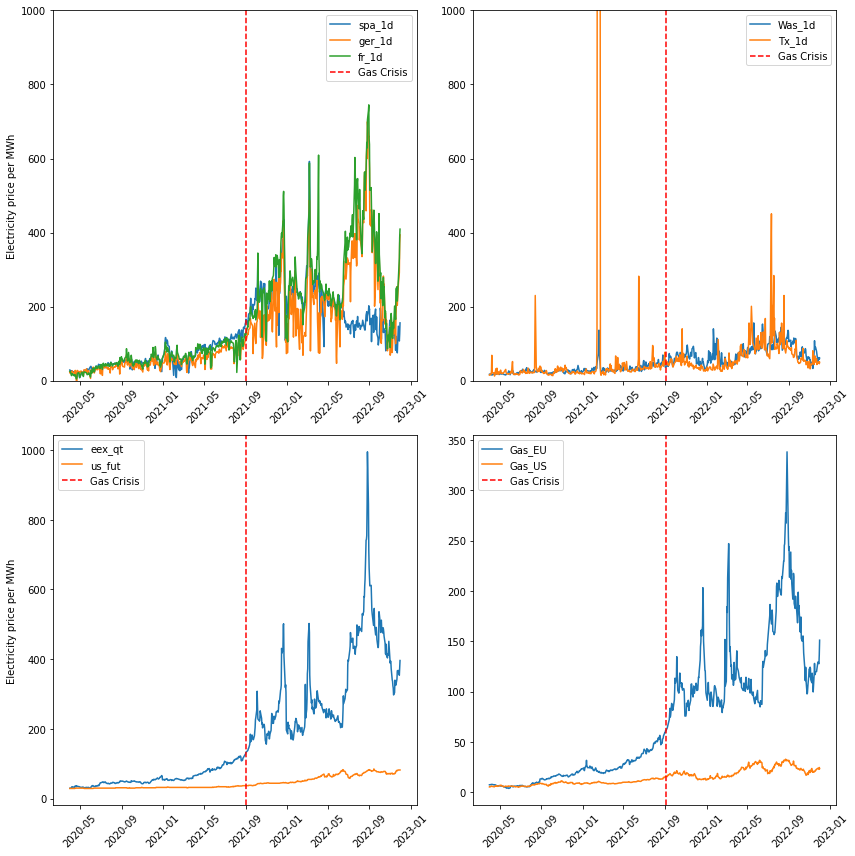

In [144]:
fig, ax = plt.subplots(2, 2,  figsize = (12, 12))

eu_vars = ['spa_1d', 'ger_1d', 'fr_1d']

us_vars = ['Was_1d', 'Tx_1d',]

fut_diff = [ 'eex_qt', 'us_fut']

gas_comp = ['Gas_EU', 'Gas_US' ]

gas_crisis = all_data.index.values[350]

xs = pd.to_datetime(pd.DataFrame(all_data.index.values,columns=['col1']).col1).dt.to_period('m')


for var in eu_vars:
    ax[0,0].plot( all_data[var]  , label = var)
    for tick in ax[0,0].get_xticklabels():
        tick.set_rotation(45)
    
for var in us_vars:
    ax[0,1].plot( all_data[var]  , label = var)
    for tick in ax[0,1].get_xticklabels():
        tick.set_rotation(45)
        
for var in fut_diff:
    ax[1,0].plot( all_data[var]  , label = var)
    for tick in ax[1,0].get_xticklabels():
        tick.set_rotation(45)
        
for var in gas_comp:
    ax[1,1].plot( all_data[var]  , label = var)
    for tick in ax[1,1].get_xticklabels():
        tick.set_rotation(45)
ax[0,0].set_ylim(0,1000)
                
        
ax[0,0].axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
ax[0,0].legend()   
ax[1,0].axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
ax[1,0].legend()  
ax[0,1].axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
ax[0,1].legend()   
ax[1,1].axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
ax[1,1].legend()

# ax[2,0].set_ylim(-200,200)
ax[0,1].set_ylim(ax[0,0].get_ylim())

ax[0,0].set_ylabel('Electricity price per MWh')
ax[1,0].set_ylabel('Electricity price per MWh')
    
plt.tight_layout()
plt.savefig('Figures/general_comparison.pdf')
plt.show()

In [14]:
break_data = 330

results_F = []

for var in log_data.keys():
    print(var)
    x = log_data[1:][var][np.logical_not(log_data[var].isnull())].values[:break_data]
    y = log_data[1:][var][np.logical_not(log_data[var].isnull())].values[break_data:]
    print(f_test(y , x))
    results_F.append(f_test(y , x))
    
results_F = pd.DataFrame(results_F, columns = ['F-score', 'p-value']).set_index(log_data.keys())

spa_1d
(1.9776535178490313, 7.10922432034522e-11)
ger_1d
(1.3136535145747912, 0.004621007984552117)
fr_1d
(1.4222131455150875, 0.00039567703549259203)
PJM_swap_1m
(2.9288154833611957, 1.1102230246251565e-16)
Gas_EU
(2.6384456918811288, 1.1102230246251565e-16)
SP500
(1.2109503426465424, 0.03353965881955134)
Ger_fw_1m
(3.3574565871886652, 1.1102230246251565e-16)
Ger_fw_1y
(9.919707432206446, 1.1102230246251565e-16)
Gas_US
(1.8708857181196759, 1.7505978888721074e-09)
Tx_1d
(0.3803600655480565, 1.0)
Was_1d
(1.7429673770945673, 7.434275517415045e-08)
eex_qt
(6.1940665580104355, 1.1102230246251565e-16)
us_fut
(5.106397321436981, 1.1102230246251565e-16)


In [145]:
log_data

spa_1d     ger_1d      fr_1d  PJM_swap_1m    Gas_EU     SP500  \
Datetime                                                                       
2020-04-01        NaN        NaN        NaN          NaN       NaN       NaN   
2020-04-02  -9.868714 -15.774815  -5.672279    -0.987662  0.935074  2.257270   
2020-04-03  -1.683136  12.166452   0.185514     2.934196 -1.191019 -1.525286   
2020-04-06   4.168018 -26.222559 -56.711305    -0.725517  4.766630  6.796823   
2020-04-07 -10.089994  30.593179  28.705097     4.043357 -0.029175 -0.160433   
...               ...        ...        ...          ...       ...       ...   
2023-04-18  36.107463 -13.796540 -11.594430    -0.850357  3.246346  0.085478   
2023-04-19  16.983747 -22.692754  -1.106389    -3.461144 -5.374943 -0.008424   
2023-04-20  -4.896182  25.858396   3.138273     7.346594  0.443815 -0.597034   
2023-04-21  -6.893582 -22.191340   4.977710    -2.095600 -0.819965  0.090279   
2023-04-24  -8.955302  15.621616 -11.220867     1.162088 -0.404953  0.085121   

            Ger_fw_1m  Ger_fw_1y    Gas_US      Tx_1d     Was_1d    eex_qt  \
Datetime                                                                     
2020-04-01        NaN        NaN       NaN        NaN        NaN       NaN   
2020-04-02   1.419612   2.555001 -2.230102  -2.420366   3.004704 -0.217534   
2020-04-03  -1.491287  -1.364246  4.349882  16.124131 -13.245865  0.352474   
2020-04-06   9.721128   5.844682  6.565603   0.449878  14.163726  6.932587   
2020-04-07   5.439158   0.884074  6.756686  33.780472 -11.358572  6.588345   
...               ...        ...       ...        ...        ...       ...   
2023-04-18   1.954671   1.798259  3.922071  14.032827   8.018480  2.627181   
2023-04-19  -0.213871  -1.934460 -6.279307  20.953197  -5.355246 -2.813643   
2023-04-20  -2.692876   0.332248  1.207798  60.371641  34.943359 -0.592006   
2023-04-21  -0.769368  -1.538443 -0.713970   3.054232  11.605333 -1.296478   
2023-04-24  -1.258193  -1.369515  1.775457 -42.221333 -21.784201 -0.755547   

              us_fut  
Datetime              
2020-04-01       NaN  
2020-04-02  0.000000  
2020-04-03  0.000000  
2020-04-06  0.000000  
2020-04-07  0.000000  
...              ...  
2023-04-18  1.652930  
2023-04-19 -1.652930  
2023-04-20  0.000000  
2023-04-21 -1.680712  
2023-04-24  3.333642  

[760 rows x 13 columns]

In [15]:
print(results_F.apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  F-score &  p-value \\
\midrule
spa\_1d      &     1.98 &     0.00 \\
ger\_1d      &     1.31 &     0.00 \\
fr\_1d       &     1.42 &     0.00 \\
PJM\_swap\_1m &     2.93 &     0.00 \\
Gas\_EU      &     2.64 &     0.00 \\
SP500       &     1.21 &     0.03 \\
Ger\_fw\_1m   &     3.36 &     0.00 \\
Ger\_fw\_1y   &     9.92 &     0.00 \\
Gas\_US      &     1.87 &     0.00 \\
Tx\_1d       &     0.38 &     1.00 \\
Was\_1d      &     1.74 &     0.00 \\
eex\_qt      &     6.19 &     0.00 \\
us\_fut      &     5.11 &     0.00 \\
\bottomrule
\end{tabular}



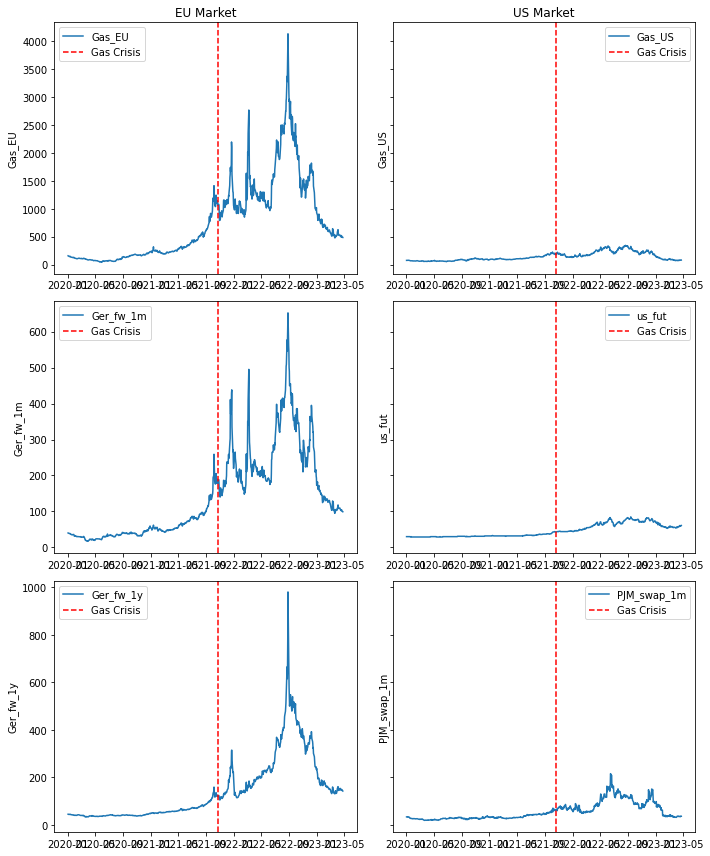

In [16]:
rows    = 3
columns = 2
 
fig, ax = plt.subplots(rows, columns, figsize = (10, 12), sharey = 'row')


variables  = np.array(['Gas_EU',
'Gas_US',
'Ger_fw_1m',
'us_fut',
'Ger_fw_1y',
'PJM_swap_1m'])

variables = variables.reshape(rows,columns)

gas_crisis = data.index.values[950]


for i in range(rows):
    for j in range(columns):
        if i == 0 and j == 0:
            ax[i,j].plot(data_garch[variables[i,j]] * 10.5*1.16  , label = variables[i,j])
        if i == 0 and j == 1:
            ax[i,j].plot(data_garch[variables[i,j]] * 35.8  , label = variables[i,j])
        if i != 0:
            ax[i,j].plot(data_garch[variables[i,j]], label = variables[i,j])    
        
        ax[i,j].axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
        ax[i,j].set_ylabel(variables[i,j])
        ax[i,j].legend()


ax[0,0].set_title('EU Market')
ax[0,1].set_title('US Market')
        
        
plt.tight_layout()
plt.savefig('Figures/prices_comparison.pdf')
plt.show()

### Empirical analysis

In [64]:
data_garch

PJM_swap_1m  Gas_EU  Gas_US  eex_qt  Ger_fw_1m  Ger_fw_1y  us_fut  \
Datetime                                                                        
2020-01-03        34.10  12.985   2.130   36.65      40.20      45.40    30.0   
2020-01-06        34.45  12.280   2.135   36.10      39.30      44.45    30.0   
2020-01-07        34.50  11.930   2.162   35.91      38.90      44.75    30.0   
2020-01-08        34.50  11.965   2.141   35.91      38.75      44.40    30.0   
2020-01-09        32.75  12.180   2.166   36.19      38.95      45.05    30.0   
...                 ...     ...     ...     ...        ...        ...     ...   
2023-01-30        62.52  55.156   2.731  138.79     129.25     171.00    59.0   
2023-01-31        62.52  57.350   2.741  147.19     143.00     176.00    59.0   
2023-02-01        39.95  59.525   2.536  150.64     140.75     185.50    58.0   
2023-02-02        42.14  57.040   2.522  143.73     133.50     175.00    59.0   
2023-02-03        38.61  57.890   2.480  145.48     141.25     179.00    58.0   

            us_fut_gas  eu_fut_gas  
Datetime                            
2020-01-03    6.273928      13.050  
2020-01-06    6.377801      12.275  
2020-01-07    6.392640      11.950  
2020-01-08    6.383736      12.000  
2020-01-09    6.428253      12.000  
...                ...         ...  
2023-01-30    7.977445      55.500  
2023-01-31    8.078350      57.352  
2023-02-01    7.425434      58.200  
2023-02-02    7.277044      56.825  
2023-02-03    7.078202      58.600  

[769 rows x 9 columns]

In [4]:
with open('fitted_models.pickle', 'rb') as handle:
    results = pickle.load(handle)

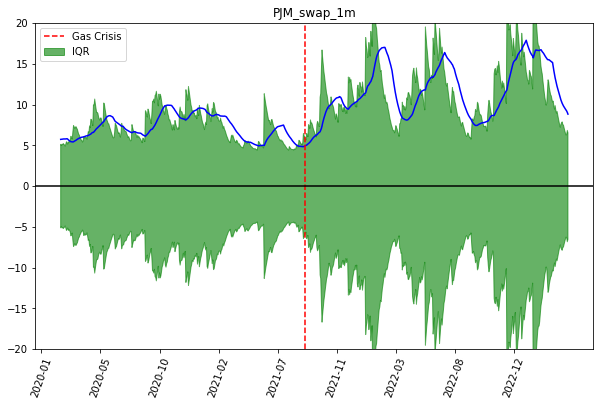

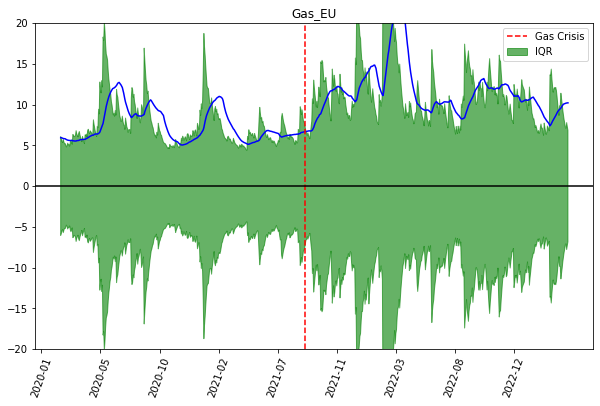

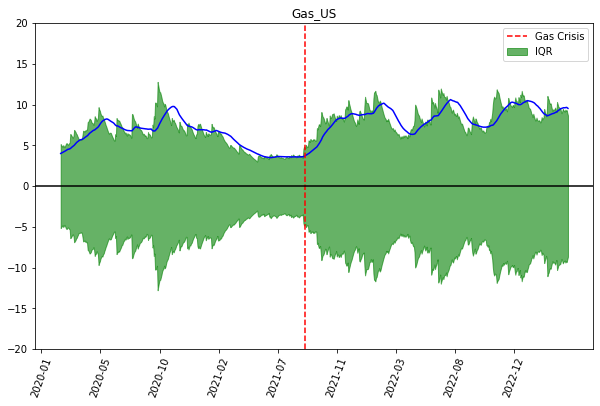

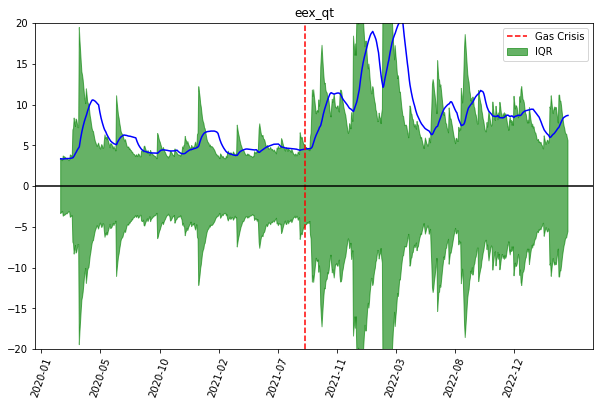

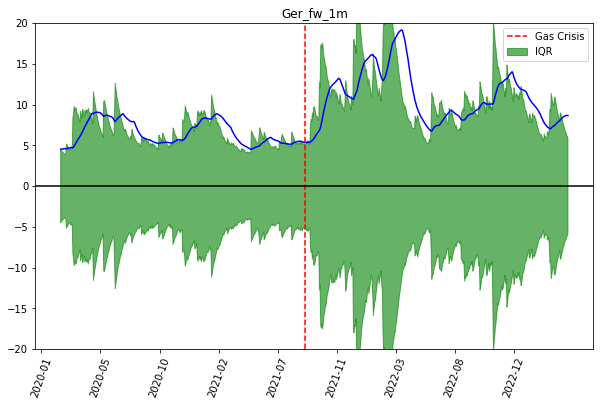

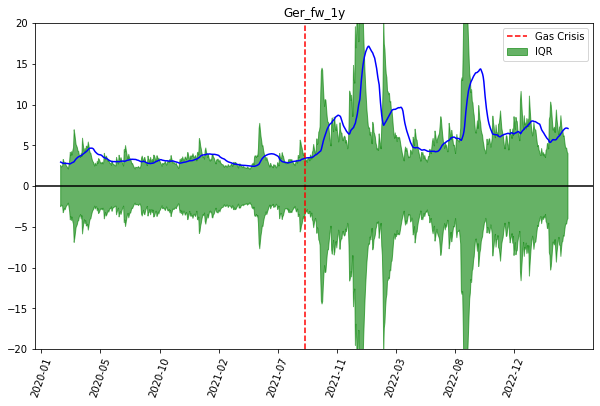

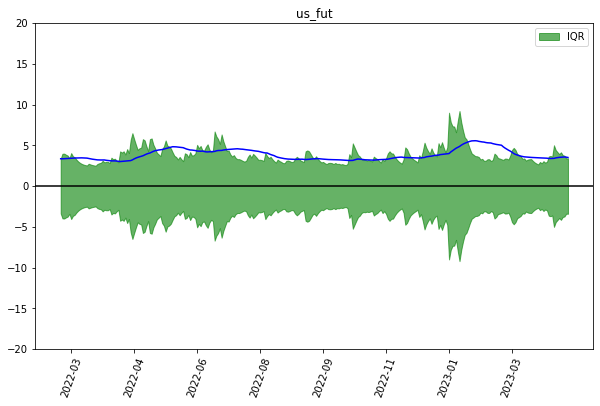

In [19]:
## Plotting stuff
rolling_delay = 30
# date_f = pd.to_datetime(pd.DataFrame(all_data.index.values,columns=['col1']).col1).dt.to_period('m')
date_f = pd.to_datetime(pd.DataFrame(data_garch.index.values,columns=['col1']).col1).dt.to_period('m')

for serie in data_garch.keys():
    
    u = results[serie][1]
    h = results[serie][2]
    df = results[serie][0][-1]
    x = range(len(h))
    plt.figure(figsize=(10,6))
    if serie == 'us_fut':
        plt.xticks(x, date_f[1+500:], rotation = 70)
    else:
        plt.xticks(x, date_f[1:], rotation = 70)
    plt.locator_params(axis='x', nbins=9)
    # plt.plot(x, np.sqrt(h) * eps_vol(df))
    top = t.ppf(0.95, df = df, scale = np.sqrt(h) )
    bot = t.ppf(0.05, df = df, scale = np.sqrt(h) )
    
    top_var = [np.mean(top[i-rolling_delay: i]) for i in range(rolling_delay, len(top))]
    
    plt.title(serie)
    plt.plot(x[rolling_delay:], top_var, color = 'blue')
    plt.fill_between(x[rolling_delay:], top[rolling_delay:], bot[rolling_delay:], where= top[rolling_delay:] >= bot[rolling_delay:], color='green', interpolate=True, alpha = 0.6, label = 'IQR')
#     plt.axvline(x = 595, color = 'orange', linestyle="--", label = 'Covid')
    if serie != 'us_fut':
        plt.axvline(x = 410, color = 'red', linestyle="--", label = 'Gas Crisis')
    plt.axhline(color = 'black')
    plt.ylim(-20,20)
    plt.legend()
    plt.show()

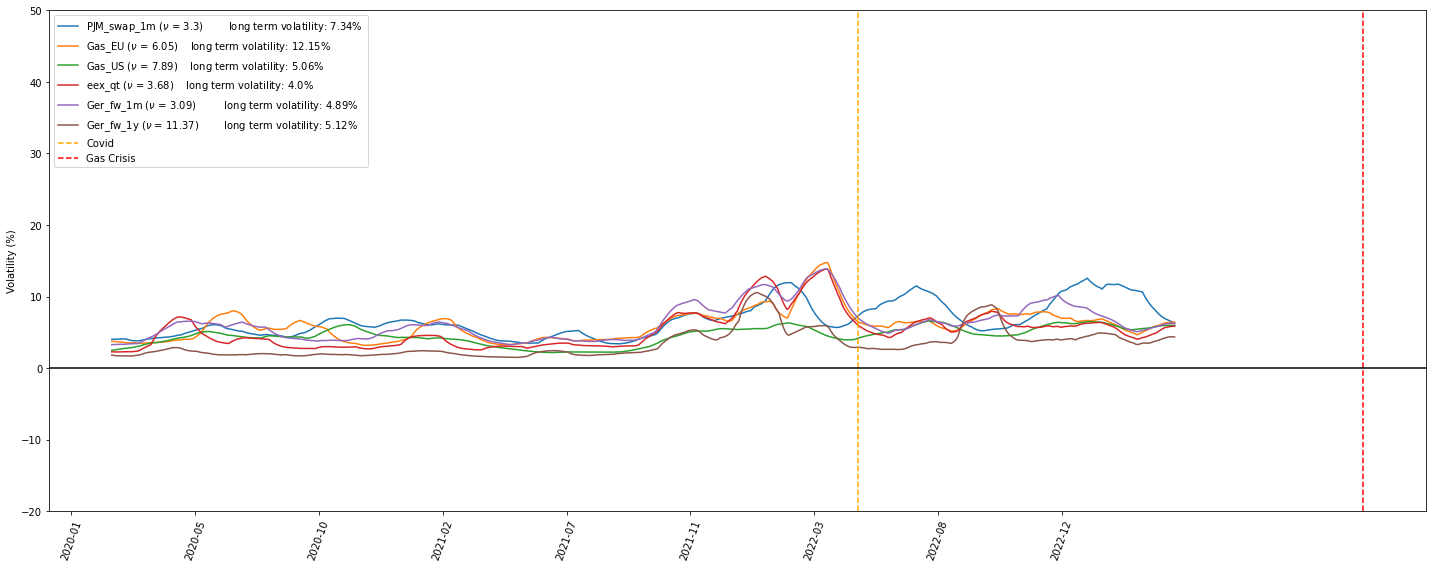

In [30]:
## Plotting stuff
rolling_delay = 30
plt.figure(figsize=(20,8))
plt.xticks(x, date_f[1:], rotation = 70)
plt.locator_params(axis='x', nbins=9)

for serie in data_garch.keys():
    
    if serie == 'us_fut':
        continue

    u = results[serie][1]
    h = results[serie][2]
    df = results[serie][0][-1]
    x = range(len(h))

#     plt.plot(x, np.sqrt(h) * eps_vol(df))
    
    top_var = [np.mean((np.sqrt(h) * eps_vol(df))[i-rolling_delay: i]) for i in range(rolling_delay, len(h))]
    
    kappa = results[serie][0][2]
    alpha = results[serie][0][3][0]
    beta  = results[serie][0][4][0]
    
    long_term_h = kappa / (1 - (alpha + beta))
    
    plt.plot(x[rolling_delay:], top_var, label = f'{serie} ($\\nu$ = {np.round(df,2)}) \t long term volatility: {np.round(long_term_h * eps_vol(df),2)}% ')
    
plt.axvline(x = 585, color = 'orange', linestyle="--", label = 'Covid')
plt.axvline(x = 960, color = 'red', linestyle="--", label = 'Gas Crisis')
plt.axhline(color = 'black')    
plt.ylim(-20,50)
plt.legend()
plt.ylabel('Volatility (%)')
plt.tight_layout()
plt.savefig('Figures/volatilities.pdf')
plt.show()

#### First simulations 

In [5]:
with open('fitted_models_crisis.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [102]:
results['ger_fut_1m'][0]

[-0.1779192483148223,
 array([0.11422709]),
 0.41912370733470494,
 array([0.05144412]),
 array([0.69161422]),
 1.5558254315222457]

In [107]:
results_bis = {}

for key in ['Gas_EU', 'Gas_US', 'eex_qt', 'us_fut_1m', 'ger_fut_1m', 'us_fut_gas', 'eu_fut_gas']:
    values = results[key][0]
    values = [values[0],values[1][0],values[2], values[3][0],values[4][0], values[5]]
    values = np.array(values)
    results_bis[key] = values

table = pd.DataFrame(results_bis).transpose()
table = table.apply(lambda x: np.round(x,2))
table = table.rename(columns={0: '$\Phi_0$', 1:'$\Phi_1$', 2: '$\kappa$', 3: '$α$', 4: '$β$', 5: '$\nu$'})

In [108]:
table

$\Phi_0$  $\Phi_1$  $\kappa$   $α$   $β$  $\nu$
Gas_EU          0.46      0.11      6.13  0.13  0.68   7.54
Gas_US          0.33     -0.10      1.72  0.06  0.84  10.43
eex_qt          0.28      0.14      2.59  0.12  0.71   4.23
us_fut_1m       0.39      0.10      0.55  0.06  0.83   2.91
ger_fut_1m     -0.18      0.11      0.42  0.05  0.69   1.56
us_fut_gas      0.37     -0.06      2.70  0.07  0.74   5.87
eu_fut_gas      0.45      0.05      6.82  0.18  0.64   9.09

In [42]:
print(table.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  \$\textbackslash Phi\_0\$ &  \$\textbackslash Phi\_1\$ &  \$\textbackslash kappa\$ &  \$lpha\$ &  \eta\$ &  \$\textbackslash nu\$ \\
\midrule
Gas\_EU     &      0.46 &      0.11 &      6.13 &     0.13 &    0.68 &   7.54 \\
Gas\_US     &      0.33 &     -0.10 &      1.72 &     0.06 &    0.84 &  10.43 \\
eex\_qt     &      0.28 &      0.14 &      2.59 &     0.12 &    0.71 &   4.23 \\
us\_fut\_1m  &      0.39 &      0.10 &      0.55 &     0.06 &    0.83 &   2.91 \\
ger\_fut\_1m &     -0.18 &      0.11 &      0.42 &     0.05 &    0.69 &   1.56 \\
us\_fut\_gas &      0.37 &     -0.06 &      2.70 &     0.07 &    0.74 &   5.87 \\
eu\_fut\_gas &      0.45 &      0.05 &      6.82 &     0.18 &    0.64 &   9.09 \\
\bottomrule
\end{tabular}



<ipython-input-42-ce1dba29c9ff>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


In [96]:
print(table.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  \$\textbackslash Phi\_0\$ &  \$\textbackslash Phi\_1\$ &  \$\textbackslash kappa\$ &  \$lpha\$ &  \eta\$ &  \$\textbackslash nu\$ \\
\midrule
PJM\_swap\_1m &      0.09 &     -0.34 &      0.51 &     0.05 &    0.87 &   2.60 \\
Gas\_EU      &      0.19 &      0.09 &      6.05 &     0.12 &    0.70 &   7.74 \\
Gas\_US      &      0.02 &     -0.07 &      1.44 &     0.06 &    0.86 &  14.82 \\
eex\_qt      &      0.06 &      0.14 &      2.94 &     0.11 &    0.71 &   4.53 \\
Ger\_fw\_1m   &     -0.04 &      0.08 &      2.02 &     0.08 &    0.79 &   4.06 \\
Ger\_fw\_1y   &      0.46 &      0.12 &      2.70 &     0.28 &    0.49 &   7.15 \\
us\_fut      &      0.24 &      0.12 &      0.42 &     0.14 &    0.74 &   9.15 \\
us\_fut\_gas  &      0.14 &     -0.06 &      2.36 &     0.08 &    0.78 &   7.23 \\
eu\_fut\_gas  &      0.20 &      0.03 &      6.85 &     0.17 &    0.65 &  10.21 \\
\bottomrule
\end{tabular}



<ipython-input-96-ce1dba29c9ff>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


In [10]:
def get_quantile(serie):
    quantile = np.quantile(serie[:,-1],0.95)
    return serie[serie[:,-1] < quantile]

In [6]:
serie = 'ger_fut_1m'
M = 10000
N = 250
crisis_idx = 0


u = results[serie][1]
h = results[serie][2]

phi0 = results[serie][0][0]
phi = results[serie][0][1]


random_shocks = np.random.randint(len(u) - crisis_idx, size=(M, N)) + crisis_idx
random_shocks = u[random_shocks]

simulation_eu = np.zeros([M,N + 1])
simulation_eu[:,0] = np.log(data_garch[serie][-1] / data_garch[serie][-2]) * 100

for step in range(1,N+1):
    
    simulation_eu[:,step] = phi0 + np.inner(phi,simulation_eu[:,step - 1].reshape((M,1))) + random_shocks[:, step - 1]
    

prices_simulation_eu = np.zeros([M,N + 1])
prices_simulation_eu[:,0] = data_garch[serie].values[-1]

for step in range(1,N+1):
    prices_simulation_eu[:,step] = prices_simulation_eu[:,step - 1] * np.exp(simulation_eu[:,step] / 100)

In [7]:
prices_simulation_eu[0,0]

325.8618375543327

In [8]:
position = 'short' ## short means selling electricity.

M0        = 30000
M         = np.empty_like(prices_simulation_eu) 
M[:,0]    = 30000
T         = 22500
num_hours = 730
V0        = prices_simulation_eu[0,0] * num_hours * np.ones(prices_simulation_eu.shape[0])

paid_eu = np.zeros_like(prices_simulation_eu)
paid_eu[:,0] = M0

for idx, prices in enumerate(prices_simulation_eu.transpose()):
    if idx == 0:
        continue
        
    V = prices * num_hours
    
    if position == 'long':
        M[:, idx] = M[:,idx-1] + (V - V0)
        
    if position == 'short':
        M[:, idx] = M[:,idx-1] - (V - V0)
    
    condition              = M[:,idx] < T
    paid_eu[:,idx][condition] = M0 - M[:,idx][condition]
    M[:,idx][condition]    = M0
    
    if position == 'long':
        V0 = V0 - paid_eu[:,idx]
        
    if position == 'short':
        V0 = V0 + paid_eu[:,idx]

tot_paid_eu = np.cumsum(paid_eu, axis=1)

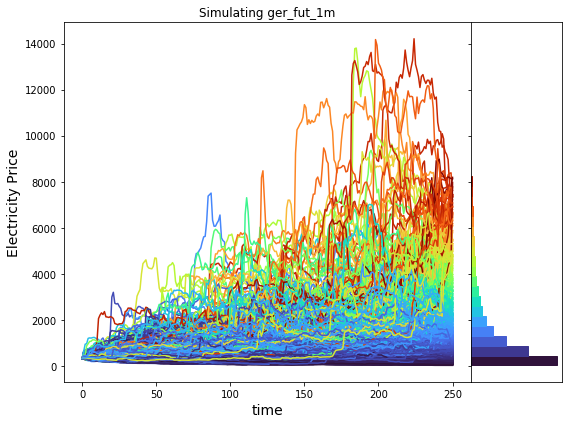

In [11]:
fancy_plot(get_quantile(prices_simulation_eu), n = prices_simulation_eu.shape[0], time_steps= prices_simulation_eu.shape[1] - 1, display = 1000,
                title = f'Simulating {serie}', savefig= True, ylabel = 'Electricity Price', figdir= 'Figures/simulation_process_eu.pdf')

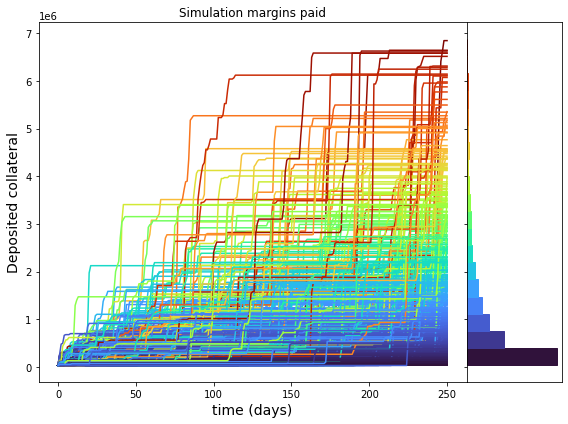

In [12]:
fancy_plot(get_quantile(tot_paid_eu), n = tot_paid_eu.shape[0], time_steps=tot_paid_eu.shape[1] - 1, display = 1000, xlabel = 'time (days)',
            savefig= True, ylabel = 'Deposited collateral', figdir= 'Figures/simulation_margins_eu.pdf', title = 'Simulation margins paid')

In [84]:
data_garch_simulations = pd.DataFrame([prices_simulation_eu[:,-1],tot_paid_eu[:,-1]]).transpose()
data_garch_simulations = data_garch_simulations.rename(columns = {0: 'electricity_price', 1:'margins'})

q05 = lambda data: data.quantile(0.05)
q95 = lambda data: data.quantile(0.95)
stats_names     = ['Mean', 'std', '05%', '95%', 'Median', 'Skew']

stats_simulation_eu = data_garch_simulations.agg([ "mean","std", q05, q95, "median", "skew"])
stats_simulation_eu.index = stats_names
stats_simulation_eu = stats_simulation_eu.transpose()
print(stats_simulation_eu.transpose().apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  electricity\_price &     margins \\
\midrule
Mean   &            2339.91 &  1803540.61 \\
std    &            6539.76 &  5122865.77 \\
05\%    &             109.60 &    46093.73 \\
95\%    &            8175.79 &  6625871.30 \\
Median &             857.71 &   600473.12 \\
Skew   &              13.31 &       13.00 \\
\bottomrule
\end{tabular}



<ipython-input-84-c1be565d6d49>:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_simulation_eu.transpose().apply(lambda x: np.round(x,2)).to_latex())


In [85]:
stats_simulation_eu

Mean           std           05%           95%  \
electricity_price  2.339908e+03  6.539765e+03    109.598413  8.175795e+03   
margins            1.803541e+06  5.122866e+06  46093.731519  6.625871e+06   

                          Median       Skew  
electricity_price     857.705920  13.313540  
margins            600473.115946  13.000763

In [13]:
# serie = 'us_fut'
serie = 'ger_fut_1m'

M = 10000
N = 250
crisis_idx = 0


u = results['us_fut_1m'][1]
h = results[serie][2]

phi0 = results[serie][0][0]
phi = results[serie][0][1]


random_shocks = np.random.randint(len(u) - crisis_idx, size=(M, N)) + crisis_idx
random_shocks = u[random_shocks]

simulation_us = np.zeros([M,N + 1])
simulation_us[:,0] = np.log(data_garch[serie][-1] / data_garch[serie][-2]) * 100

for step in range(1,N+1):
    
    simulation_us[:,step] = phi0 + np.inner(phi,simulation_us[:,step - 1].reshape((M,1))) + random_shocks[:, step - 1]
    

prices_simulation_us = np.zeros([M,N + 1])
prices_simulation_us[:,0] = data_garch[serie].values[-1]

for step in range(1,N+1):
    prices_simulation_us[:,step] = prices_simulation_us[:,step - 1] * np.exp(simulation_us[:,step] / 100)

In [14]:
position = 'short' ## short means selling electricity.

M0        = 30000
M         = np.empty_like(prices_simulation_us) 
M[:,0]    = 30000
T         = 22500
num_hours = 730
V0        = prices_simulation_us[0,0] * num_hours * np.ones(prices_simulation_us.shape[0])

paid_us = np.zeros_like(prices_simulation_us)
paid_us[:,0] = M0

for idx, prices in enumerate(prices_simulation_us.transpose()):
    if idx == 0:
        continue
        
    V = prices * num_hours
    
    if position == 'long':
        M[:, idx] = M[:,idx-1] + (V - V0)
        
    if position == 'short':
        M[:, idx] = M[:,idx-1] - (V - V0)
    
    condition              = M[:,idx] < T
    paid_us[:,idx][condition] = M0 - M[:,idx][condition]
    M[:,idx][condition]    = M0
    
    if position == 'long':
        V0 = V0 - paid_us[:,idx]
        
    if position == 'short':
        V0 = V0 + paid_us[:,idx]

tot_paid_us = np.cumsum(paid_us, axis=1)

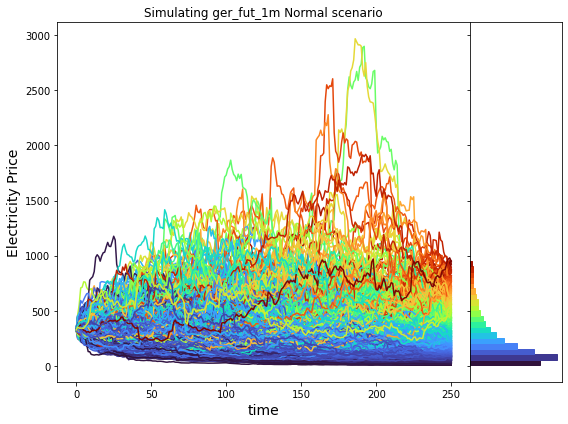

In [15]:
fancy_plot(get_quantile(prices_simulation_us), n = prices_simulation_us.shape[0], time_steps= prices_simulation_us.shape[1] - 1, display = 1000,
                title = f'Simulating {serie} Normal scenario', ylabel = 'Electricity Price', savefig= True, figdir= 'Figures/simulation_process_us.pdf')

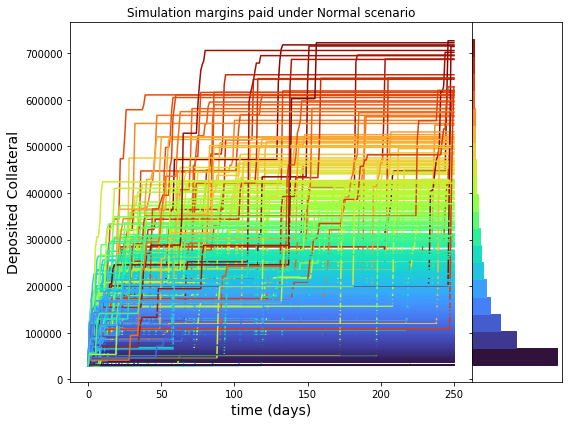

In [ ]:
fancy_plot(get_quantile(tot_paid_us), n = tot_paid_us.shape[0], time_steps=tot_paid_us.shape[1] - 1, display = 1000, xlabel = 'time (days)',
                 ylabel = 'Deposited Collateral', savefig= True, figdir= 'Figures/simulation_margins_us.pdf', title = 'Simulation margins paid under Normal scenario')

In [88]:
data_garch_simulation_us = pd.DataFrame([prices_simulation_us[:,-1],tot_paid_us[:,-1]]).transpose()
data_garch_simulation_us = data_garch_simulation_us.rename(columns = {0: 'electricity_price', 1:'margins'})

q05 = lambda data: data.quantile(0.05)
q95 = lambda data: data.quantile(0.95)
stats_names     = ['Mean', 'std', '05%', '95%', 'Median', 'Skew']

stats_simulation_us = data_garch_simulation_us.agg([ "mean","std", q05, q95, "median", "skew"])
stats_simulation_us.index = stats_names
stats_simulation_us = stats_simulation_us.transpose()
print(stats_simulation_us.apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &       Mean &        std &       05\% &        95\% &     Median &  Skew \\
\midrule
electricity\_price &     274.92 &     385.85 &     26.74 &     884.14 &     157.73 &  5.44 \\
margins           &  216032.86 &  321801.83 &  37128.35 &  731030.53 &  106927.77 &  5.54 \\
\bottomrule
\end{tabular}



<ipython-input-88-b80866bf083b>:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_simulation_us.apply(lambda x: np.round(x,2)).to_latex())


In [89]:
stats_simulation_us

Mean            std           05%            95%  \
electricity_price     274.915776     385.847647     26.736068     884.137353   
margins            216032.864257  321801.833098  37128.353445  731030.530730   

                          Median      Skew  
electricity_price     157.731423  5.440231  
margins            106927.774170  5.543424

In [90]:
diffs = stats_simulation_eu - stats_simulation_us

all_stats = pd.concat([stats_simulation_eu.transpose().rename(columns = {'electricity_price': 'electricity_price_eu', 'margins': 'Deposited collateral'}),
                       stats_simulation_us.transpose().rename(columns = {'electricity_price': 'electricity_price_normal_scenario',
                                                                         'margins': 'Deposited collateral'}),
                      diffs.transpose().rename(columns = {'electricity_price': 'Prices', 'margins': 'Deposited collateral'})],
                      axis = 1)

In [91]:
all_stats

electricity_price_eu  Deposited collateral  \
Mean             2339.908121          1.803541e+06   
std              6539.764781          5.122866e+06   
05%               109.598413          4.609373e+04   
95%              8175.794521          6.625871e+06   
Median            857.705920          6.004731e+05   
Skew               13.313540          1.300076e+01   

        electricity_price_normal_scenario  Deposited collateral       Prices  \
Mean                           274.915776         216032.864257  2064.992345   
std                            385.847647         321801.833098  6153.917134   
05%                             26.736068          37128.353445    82.862345   
95%                            884.137353         731030.530730  7291.657168   
Median                         157.731423         106927.774170   699.974497   
Skew                             5.440231              5.543424     7.873309   

        Deposited collateral  
Mean            1.587508e+06  
std             4.801064e+06  
05%             8.965378e+03  
95%             5.894841e+06  
Median          4.935453e+05  
Skew            7.457339e+00

In [59]:
print(all_stats.apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  electricity\_price\_eu &  Deposited collateral &  electricity\_price\_normal\_scenario &  Deposited collateral &   Prices &  Deposited collateral \\
\midrule
Mean   &               2283.70 &            1786512.59 &                             275.56 &             211615.58 &  2008.13 &            1574897.01 \\
std    &               5792.33 &            4796674.97 &                             377.37 &             322392.90 &  5414.96 &            4474282.07 \\
05\%    &                117.47 &              45935.67 &                              26.34 &              30000.00 &    91.12 &              15935.67 \\
95\%    &               8228.78 &            6887885.60 &                             906.00 &             713711.51 &  7322.78 &            6174174.08 \\
Median &                850.43 &             580296.01 &                             158.96 &             104364.98 &   691.47 &             475931.03 \\
Skew   &                 15.77

<ipython-input-59-7caef22b67b9>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(all_stats.apply(lambda x: np.round(x,2)).to_latex())


In [ ]:
prices_simulation_eu.mean(axis = 0)

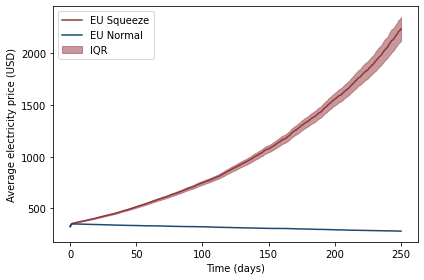

In [67]:
colors = ['#90353b', '#1d4971', 'green']

q1 = 0.80
q2 = 0.995

means = prices_simulation_eu.mean(axis = 0)
stds  = prices_simulation_eu.std(axis = 0)/np.sqrt(10000)

top_q1 = means + 2*stds
bot_q1 = means - 2*stds

# top_q1 = np.quantile(prices_simulation_eu, q = q1, axis = 0)
# bot_q1 = np.quantile(prices_simulation_eu, q = 1-q1, axis = 0)

top_q2 = np.quantile(prices_simulation_eu, q = q2, axis = 0)
bot_q2 = np.quantile(prices_simulation_eu, q = 1-q2, axis = 0)

plt.plot(means, label = 'EU Squeeze',color = colors[0])
plt.fill_between(range(top_q1.shape[0]),top_q1, bot_q1, where= top_q1 >= bot_q1, color=colors[0], interpolate=True, alpha = 0.5, label = 'IQR')
plt.plot(prices_simulation_us.mean(axis = 0),label = 'EU Normal',color = colors[1])
plt.xlabel('Time (days)')
plt.ylabel('Average electricity price (USD)')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/avg_price_simulation.pdf')
plt.show()

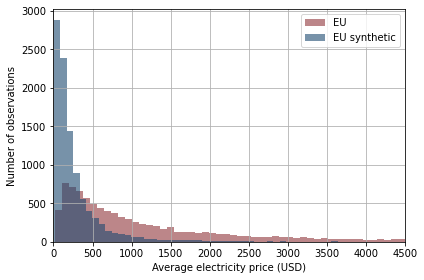

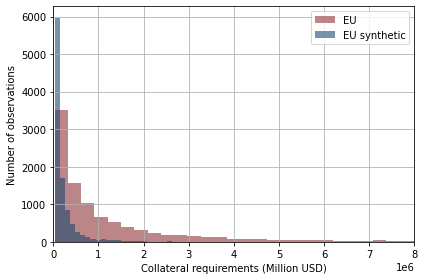

In [115]:
cut = 4500

p_eu = prices_simulation_eu[:,-1][prices_simulation_eu[:,-1] < cut]
p_us = prices_simulation_us[:,-1][prices_simulation_us[:,-1] < cut]
plt.hist(p_eu,50, color = colors[0], density=False, alpha = 0.6, label = 'EU')
plt.hist(p_us,50, color = colors[1], density=False, alpha = 0.6, label = 'EU synthetic')
plt.xlim(0,cut)
# plt.ylim(0,0.0025)
plt.ylabel('Number of observations')
plt.xlabel('Average electricity price (USD)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('Figures/distributions_pdf.pdf')
plt.show()

cut = 8e6

p_eu = tot_paid_eu[:,-1][prices_simulation_eu[:,-1] < cut]
p_us = tot_paid_us[:,-1][prices_simulation_us[:,-1] < cut]
plt.hist(p_eu,700, color = colors[0], density=False, alpha = 0.6, label = 'EU')
plt.hist(p_us,50 , color = colors[1], density=False, alpha = 0.6, label = 'EU synthetic')
plt.xlim(0,cut)
# plt.ylim(0,0.0025)
plt.ylabel('Number of observations')
plt.xlabel('Collateral requirements (Million USD)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('Figures/distributions_collateral.pdf')
plt.show()

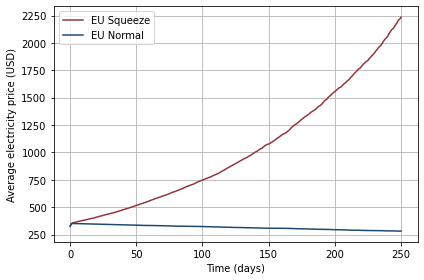

In [127]:
colors = ['#90353b', '#1d4971', 'green']

q1 = 0.90
q2 = 0.90

top_q1 = np.quantile(prices_simulation_eu, q = q1, axis = 0)
bot_q1 = np.quantile(prices_simulation_eu, q = 1-q1, axis = 0)

top_q2 = np.quantile(prices_simulation_us, q = q2, axis = 0)
bot_q2 = np.quantile(prices_simulation_us, q = 1-q2, axis = 0)

plt.plot(prices_simulation_eu.mean(axis = 0), label = 'EU Squeeze',color = colors[0])
# plt.fill_between(range(top_q1.shape[0]),top_q1, bot_q1, where= top_q1 >= bot_q1, color=colors[0], interpolate=True, alpha = 0.6, label = '90% IQR')
# plt.fill_between(range(top_q2.shape[0]),top_q2, bot_q2, where= top_q2 >= bot_q2, color=colors[1], interpolate=True, alpha = 0.6, label = '90% IQR')
plt.plot(prices_simulation_us.mean(axis = 0),label = 'EU Normal',color = colors[1])
plt.xlabel('Time (days)')
plt.ylabel('Average electricity price (USD)')
plt.legend(loc = 'upper left')
plt.grid()
plt.tight_layout()
plt.savefig('Figures/avg_price_simulation.pdf')
plt.show()

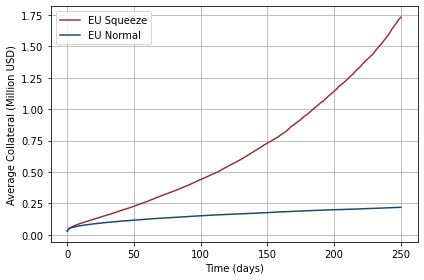

In [126]:
q1 = 0.90
q2 = 0.90

top_q1 = np.quantile(tot_paid_eu, q = q1, axis = 0)
bot_q1 = np.quantile(tot_paid_eu, q = 1-q1, axis = 0)

top_q2 = np.quantile(tot_paid_us, q = q2, axis = 0)
bot_q2 = np.quantile(tot_paid_us, q = 1-q2, axis = 0)

# plt.plot(tot_paid_eu.mean(axis = 0), label = 'EU Squeeze', color = colors[0])
plt.plot(np.mean(tot_paid_eu, axis = 0)/1e6, label = 'EU Squeeze', color = colors[0])
# plt.fill_between(range(top_q1.shape[0]),top_q1, bot_q1, where= top_q1 >= bot_q1, color=colors[0], interpolate=True, alpha = 0.6, label = '90% IQR')
# plt.fill_between(range(top_q2.shape[0]),top_q2, bot_q2, where= top_q2 >= bot_q2, color=colors[1], interpolate=True, alpha = 0.6, label = '90% IQR')
plt.plot(tot_paid_us.mean(axis = 0)/1e6,label = 'EU Normal', color = colors[1])
plt.xlabel('Time (days)')
plt.ylabel('Average Collateral (Million USD)')
plt.legend(loc = 'upper left')
plt.grid()
plt.tight_layout()
plt.savefig('Figures/avg_margin_paid_simulation.pdf')
plt.show()

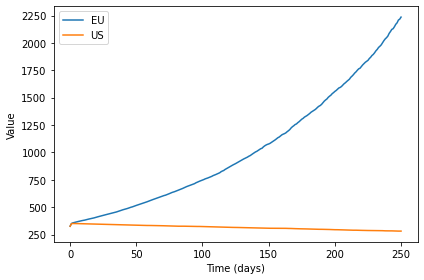

In [75]:
plt.plot(prices_simulation_eu.mean(axis = 0), label = 'EU')
plt.plot(prices_simulation_us.mean(axis = 0),label = 'US')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/avg_price_simulation.pdf')
plt.show()

In [166]:
print(0.2085 / (1 - (0.2108 + 0.7479)))
print(0.3241 / (1 - (0.0548 + 0.8713)))

5.048426150121065
4.385656292286869


#### Simulating the non squeeze period

In [104]:
serie = 'eex_qt'
M = 10000
N = 250
crisis_idx = 410


u = results[serie][1]
h = results[serie][2]

phi0 = results[serie][0][0]
phi = results[serie][0][1]


random_shocks = np.random.randint(len(u) - crisis_idx, size=(M, N)) ## Shocks between 0 and 410
random_shocks = u[random_shocks]

simulation_eu = np.zeros([M,N + 1])
simulation_eu[:,0] = np.log(data_garch[serie][1 + crisis_idx] / data_garch[serie][crisis_idx]) * 100 ## Starting crisis

for step in range(1,N+1):
    
    simulation_eu[:,step] = phi0 + np.inner(phi,simulation_eu[:,step - 1].reshape((M,1))) + random_shocks[:, step - 1]
    

prices_simulation_eu = np.zeros([M,N + 1])
prices_simulation_eu[:,0] = data_garch[serie].values[crisis_idx] # first price 

for step in range(1,N+1):
    prices_simulation_eu[:,step] = prices_simulation_eu[:,step - 1] * np.exp(simulation_eu[:,step] / 100) 

In [235]:
position = 'short' ## short means selling electricity.

M0        = 30000
M         = np.empty_like(prices_simulation_eu) 
M[:,0]    = 30000
T         = 22500
num_hours = 730
V0        = prices_simulation_eu[0,0] * num_hours * np.ones(prices_simulation_eu.shape[0])

paid_eu = np.zeros_like(prices_simulation_eu)
paid_eu[:,0] = M0

for idx, prices in enumerate(prices_simulation_eu.transpose()):
    if idx == 0:
        continue
        
    V = prices * num_hours
    
    if position == 'long':
        M[:, idx] = M[:,idx-1] + (V - V0)
        
    if position == 'short':
        M[:, idx] = M[:,idx-1] - (V - V0)
    
    condition              = M[:,idx] < T
    paid_eu[:,idx][condition] = M0 - M[:,idx][condition]
    M[:,idx][condition]    = M0
    
    if position == 'long':
        V0 = V0 - paid_eu[:,idx]
        
    if position == 'short':
        V0 = V0 + paid_eu[:,idx]

tot_paid_eu = np.cumsum(paid_eu, axis=1)

NameError: name 'prices_simulation_eu' is not defined

In [106]:
data_garch_simulations = pd.DataFrame([prices_simulation_eu[:,-1],tot_paid_eu[:,-1]]).transpose()
data_garch_simulations = data_garch_simulations.rename(columns = {0: 'electricity_price', 1:'margins'})

stats_simulation_eu = data_garch_simulations.agg([ "mean","std", "min", "max", "median", "skew"]).transpose()
print(stats_simulation_eu.transpose().apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  electricity\_price &     margins \\
\midrule
mean   &             206.58 &   118554.76 \\
std    &             141.65 &   103874.72 \\
min    &              25.42 &    30000.00 \\
max    &            1837.13 &  1353974.52 \\
median &             170.19 &    88397.82 \\
skew   &               2.68 &        2.90 \\
\bottomrule
\end{tabular}



#### Simulating with the "real" margin

In [117]:
def sigma_formula(rs, lam):
    weights = np.array([lam ** i for i in range(1,len(rs)+ 1)])
    
    S =  (lam - (lam ** (len(rs)+1)))/(1 - lam)
    
    sigma_2 = (np.inner(( rs ** 2) , weights))/S
    
    return np.sqrt(sigma_2)

def risk_multiplier(rs, sigs, alpha = 0.95):
    q = np.quantile(rs / sigs, alpha)
    Q = np.quantile(rs / sigs, 1  - alpha)
    
    return 0.5 * (np.abs(q) + np.abs(Q))


lam = 0.99
ecc_window = 255
N = 251
M = 1000
crisis_idx = 410
serie = 'eex_qt'

M0        = 30000
T         = 22500
num_hours = 730
V0        = data_garch[serie].values[-1] * num_hours
l = np.sqrt(30)

u    = results[serie][1]
h    = results[serie][2]
phi0 = results[serie][0][0]
phi  = results[serie][0][1]
df   = results[serie][0][-1]

returns = np.zeros([M, N + 2 * ecc_window])
prices_eu  = np.zeros([M, N + 2 * ecc_window])
sigmas  = np.zeros([M, N + 2 * ecc_window])
margins = np.zeros([M, N + 1])

margins[:,0] = M0

first_returns = np.log(data_garch[serie]).diff().values[-(ecc_window * 2):]
first_prices_eu  = data_garch[serie][-(ecc_window * 2 ):]

for i in range(M):
    returns[i,:2 * ecc_window] = first_returns
    prices_eu[i ,:2 * ecc_window] = first_prices_eu
    
    for time in range(ecc_window):
        sigmas[i ,ecc_window + time] = sigma_formula(returns[i, time : ecc_window + time ], lam)
        

returns = returns[:, ecc_window:]
prices_eu  = prices_eu[: , ecc_window:]
sigmas  = sigmas[: , ecc_window:]       
     
    
random_shocks = np.random.randint(len(u) - crisis_idx, size=(M, N)) + crisis_idx
random_shocks = u[random_shocks]

simulation_eu = np.zeros([M,N + 1])
simulation_eu[:,0] = np.log(data_garch[serie][-1] / data_garch[serie][-2]) * 100

Rs = []
Pts = []

for step in range(1,N+1):
    
    simulation_eu[:,step] = (phi0 + np.inner(phi,simulation_eu[:,step - 1].reshape((M,1))) + random_shocks[:, step - 1]) / 100
    returns[: ,ecc_window + step - 1] = simulation_eu[:,step]
    prices_eu[:,ecc_window + step - 1] = prices_eu[:,ecc_window + step - 2] * np.exp(simulation_eu[:,step])
    
    for m in range(M):
        sigmas[m,ecc_window + step - 1] = sigma_formula(returns[m, step - 1:ecc_window + step - 1], lam)
        
        R  = risk_multiplier(returns[m,step - 1: ecc_window + step - 1], sigmas[m,step - 1: ecc_window + step - 1])
        Pt = (num_hours * prices_eu[m,ecc_window + step - 1]) - V0
        margins[m, step] = l * Pt * sigmas[m,ecc_window + step - 1] * R
        if m == 1:
            Pts.append(Pt)
            Rs.append(R)
margins = margins[:,1:]

In [118]:
position = 'short' ## short means selling electricity.

positive_margins = margins.copy()
positive_margins[positive_margins < 0] = 0
thersholds = positive_margins.copy() * 0.75

num_hours = 730
V0        = prices_eu[:,254][0] * num_hours * np.ones(prices_eu.shape[0])

paid_eu = np.zeros_like(prices_eu[:,255:])
paid_eu[:,0] = M0

balance = np.zeros(positive_margins.shape[0])

for idx, price in enumerate(prices_eu.transpose()[255:,:]):
    if idx == 0:
        continue
        
    V = price * num_hours
    
#     if position == 'long':
#         positive_margins[:, idx] = positive_margins[:, idx] + (V - V0)
        
    if position == 'short':
        balance = positive_margins[:, idx] - (V - V0)
    
    condition                 = balance < thersholds[:, idx]
    paid_eu[:,idx][condition] = positive_margins[:,idx][condition] - balance[condition] 
    
#     if position == 'long':
#         V0 = V0 - paid_eu[:,idx]
        
    if position == 'short':
        V0 = V0 + paid_eu[:,idx]

tot_paid_eu = np.cumsum(paid_eu, axis=1)

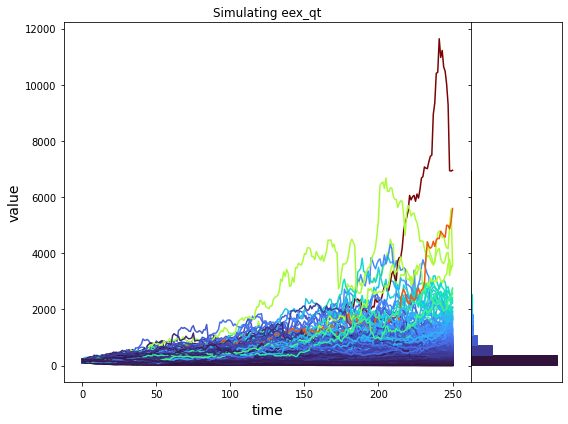

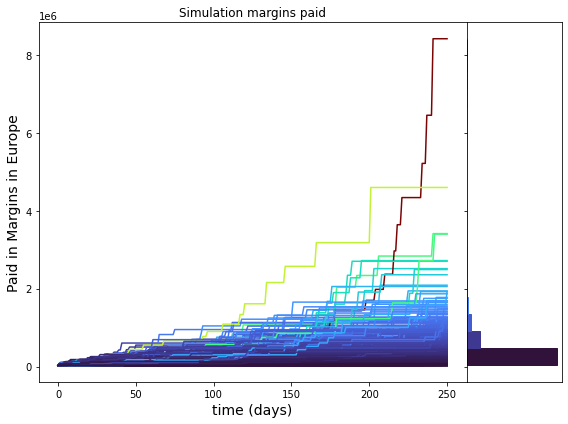

\begin{tabular}{lrr}
\toprule
{} &  electricity\_price\_squeeze &  margins\_squeeze \\
\midrule
mean   &                     346.14 &        327862.22 \\
std    &                     504.01 &        489763.89 \\
median &                     192.63 &        177981.10 \\
\bottomrule
\end{tabular}



In [119]:
fancy_plot(prices_eu[:,255:], n = prices_eu[:,255:].shape[0], time_steps= prices_eu[:,255:].shape[1] - 1, display = 1000,
                title = f'Simulating {serie}', savefig= True, figdir= 'Figures/simulation_process_eu_squeeze.pdf')

fancy_plot(tot_paid_eu, n = tot_paid_eu.shape[0], time_steps=tot_paid_eu.shape[1] - 1, display = tot_paid_eu.shape[0], xlabel = 'time (days)',
                 ylabel = 'Paid in Margins in Europe', savefig= True, figdir= 'Figures/simulation_margins_eu_squeeze.pdf', title = 'Simulation margins paid')

data_garch_simulations = pd.DataFrame([prices_eu[:,-1],tot_paid_eu[:,-1]]).transpose()
data_garch_simulations = data_garch_simulations.rename(columns = {0: 'electricity_price', 1:'margins'})

stats_squeeze_eu = data_garch_simulations.agg([ "mean","std", "median"])
stats_squeeze_eu = stats_squeeze_eu.rename(columns = {'electricity_price': 'electricity_price_squeeze' , 'margins':'margins_squeeze'})
print(stats_squeeze_eu.apply(lambda x: np.round(x,2)).to_latex())

In [120]:
prices_eu_squeeze = prices_eu[:,-1]
margin_eu_squeeze = tot_paid_eu[:,-1]

$\LARGE \text{The following chunck of code is for the same serie in the} $

$\LARGE \text{non-squeeze period, thus changing the initial price and the shocks}$

In [121]:
def sigma_formula(rs, lam):
    weights = np.array([lam ** i for i in range(1,len(rs)+ 1)])
    
    S =  (lam - (lam ** (len(rs)+1)))/(1 - lam)
    
    sigma_2 = (np.inner(( rs ** 2) , weights))/S
    
    return np.sqrt(sigma_2)

def risk_multiplier(rs, sigs, alpha = 0.95):
    q = np.quantile(rs / sigs, alpha)
    Q = np.quantile(rs / sigs, 1  - alpha)
    
    return 0.5 * (np.abs(q) + np.abs(Q))

data_eex_qt_bis = data_eex_qt[crisis_idx:].copy()

lam = 0.99
ecc_window = 255
N = 251
M = 1000
crisis_idx = 410
serie = 'eex_qt'

M0        = 30000
T         = 22500
num_hours = 730
V0        = data_eex_qt_bis.sort_index().iloc[601,:][0] * num_hours
l = np.sqrt(30)

u    = results[serie][1]
h    = results[serie][2]
phi0 = results[serie][0][0]
phi  = results[serie][0][1]
df   = results[serie][0][-1]

returns = np.zeros([M, N + 2 * ecc_window])
prices_eu  = np.zeros([M, N + 2 * ecc_window])
sigmas  = np.zeros([M, N + 2 * ecc_window])
margins = np.zeros([M, N + 1])

margins[:,0] = M0

first_returns = np.log(data_eex_qt_bis.sort_index()).diff().values[-(ecc_window * 2):].flatten()
first_prices_eu  = data_eex_qt_bis.sort_index()[-(ecc_window * 2 ):]

for i in range(M):
    returns[i,:2 * ecc_window] = first_returns
    prices_eu[i ,:2 * ecc_window] = first_prices_eu.values.flatten()
    
    for time in range(ecc_window):
        sigmas[i ,ecc_window + time] = sigma_formula(returns[i, time : ecc_window + time ], lam)
        

returns = returns[:, ecc_window:]
prices_eu  = prices_eu[: , ecc_window:]
sigmas  = sigmas[: , ecc_window:]
     
    
random_shocks = np.random.randint(len(u) - crisis_idx, size=(M, N))
random_shocks = u[random_shocks]

simulation_eu = np.zeros([M,N + 1])
simulation_eu[:,0] = np.log(data_eex_qt_bis.sort_index().iloc[-1,0] / data_eex_qt_bis.sort_index().iloc[-2,0]) * 100

Rs = []
Pts = []

for step in range(1,N+1):
    
    simulation_eu[:,step] = (phi0 + np.inner(phi,simulation_eu[:,step - 1].reshape((M,1))) + random_shocks[:, step - 1]) / 100
    returns[: ,ecc_window + step - 1] = simulation_eu[:,step]
    prices_eu[:,ecc_window + step - 1] = prices_eu[:,ecc_window + step - 2] * np.exp(simulation_eu[:,step])
    
    for m in range(M):
        sigmas[m,ecc_window + step - 1] = sigma_formula(returns[m, step - 1:ecc_window + step - 1], lam)
        
        R  = risk_multiplier(returns[m,step - 1: ecc_window + step - 1], sigmas[m,step - 1: ecc_window + step - 1])
        Pt = (num_hours * prices_eu[m,ecc_window + step - 1]) - V0
        margins[m, step] = l * Pt * sigmas[m,ecc_window + step - 1] * R
        if m == 1:
            Pts.append(Pt)
            Rs.append(R)
            
margins = margins[:,1:]

In [122]:
position = 'short' ## short means selling electricity.

positive_margins = margins.copy()
positive_margins[positive_margins < 0] = 0
thersholds = positive_margins.copy() * 0.75

num_hours = 730
V0        = prices_eu[:,254][0] * num_hours * np.ones(prices_eu.shape[0])

paid_eu = np.zeros_like(prices_eu[:,255:])
paid_eu[:,0] = M0

balance = np.zeros(positive_margins.shape[0])

for idx, price in enumerate(prices_eu.transpose()[255:,:]):
    if idx == 0:
        continue
        
    V = price * num_hours
    
#     if position == 'long':
#         positive_margins[:, idx] = positive_margins[:, idx] + (V - V0)
        
    if position == 'short':
        balance = positive_margins[:, idx] - (V - V0)
    
    condition                 = balance < thersholds[:, idx]
    paid_eu[:,idx][condition] = positive_margins[:,idx][condition] - balance[condition] 
    
#     if position == 'long':
#         V0 = V0 - paid_eu[:,idx]
        
    if position == 'short':
        V0 = V0 + paid_eu[:,idx]

tot_paid_eu = np.cumsum(paid_eu, axis=1)

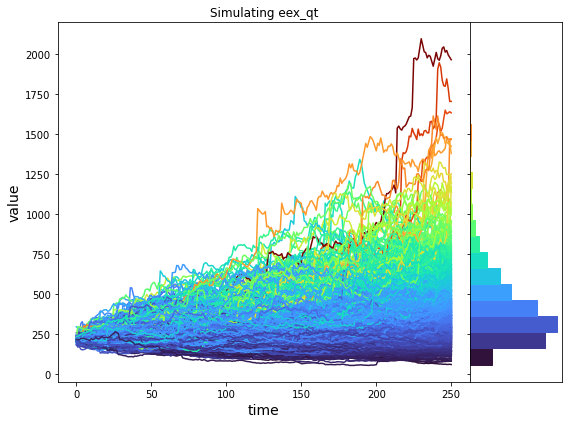

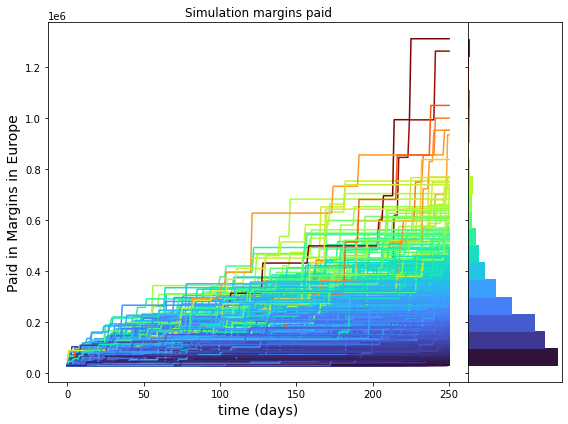

\begin{tabular}{lrr}
\toprule
{} &  electricity\_price\_non\_squeeze &  margins\_non\_squeeze \\
\midrule
mean   &                         407.99 &            209208.46 \\
std    &                         224.82 &            162740.61 \\
median &                         358.86 &            173819.73 \\
\bottomrule
\end{tabular}



In [123]:
fancy_plot(prices_eu[:,255:], n = prices_eu[:,255:].shape[0], time_steps= prices_eu[:,255:].shape[1] - 1, display = 1000,
                title = f'Simulating {serie}', savefig= True, figdir= 'Figures/simulation_process_eu_non_squeeze.pdf')

fancy_plot(tot_paid_eu, n = tot_paid_eu.shape[0], time_steps=tot_paid_eu.shape[1] - 1, display = tot_paid_eu.shape[0], xlabel = 'time (days)',
                 ylabel = 'Paid in Margins in Europe', savefig= True, figdir= 'Figures/simulation_margins_eu_non_squeeze.pdf', title = 'Simulation margins paid')

data_garch_simulations = pd.DataFrame([prices_eu[:,-1],tot_paid_eu[:,-1]]).transpose()
data_garch_simulations = data_garch_simulations.rename(columns = {0: 'electricity_price', 1:'margins'})

stats_non_squeeze_eu = data_garch_simulations.agg([ "mean","std", "median"])
stats_non_squeeze_eu = stats_non_squeeze_eu.rename(columns = {'electricity_price': 'electricity_price_non_squeeze' , 'margins':'margins_non_squeeze'})
print(stats_non_squeeze_eu.apply(lambda x: np.round(x,2)).to_latex())

In [124]:
prices_eu_non_squeeze = prices_eu[:,-1]
margin_eu_non_squeeze = tot_paid_eu[:,-1]

In [ ]:
def test_quantile(x,y, q = 0.5, n_rep = 10000):
    
    def calc_p_value(x, value):
        if value < 0:
            value = - value
            x = -x

        result = np.sum([med > value for med in x]) / len(x)

        return result

    M = len(x) + len(y)
    rand = np.random.randint(0,2,(n_rep, M))
     
    value = np.quantile(x, q) - np.quantile(y, q)
    
    z = np.array([*x, *y])
    sim = []
    for n in range(n_rep):
        sim.append(np.quantile(z[rand[n] == 0], q) - np.quantile(z[rand[n] == 1], q))
        
    sim = np.array(sim)
    
    p_val = calc_p_value(sim, value)
    print(p_val)
    
    return p_val

In [83]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)

    dfn = x.size-1 #define degrees of freedom numerator
    dfd = y.size-1 #define degrees of freedom denominator
    
    var1 = np.var(x, ddof=1)
    var2 = np.var(y, ddof=1)
    if var1 > var2:
        f = var1/var2 #calculate F test statistic
        p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic
    else:
        f = var2/var1 #calculate F test statistic
        p = 1-scipy.stats.f.cdf(f, dfd, dfn) #find p-value of F test statistic        
    return f, p

In [85]:
print('means')
print(scipy.stats.ttest_ind(prices_eu_squeeze, prices_eu_non_squeeze)[1])
print(scipy.stats.ttest_ind(margin_eu_squeeze, margin_eu_non_squeeze)[1])

print('variance')
print(f_test(prices_eu_squeeze, prices_eu_non_squeeze)[1])
print(f_test(margin_eu_squeeze, margin_eu_non_squeeze)[1])

print('medians')
_ = test_median(prices_eu_squeeze, prices_eu_non_squeeze)
_ = test_median(margin_eu_squeeze, margin_eu_non_squeeze)

means
0.9821246365510181
6.450026026033627e-15
variance
1.1102230246251565e-16
1.1102230246251565e-16
medians
0.0
0.1163


In [76]:
diff_med_margin

7987.938177541451

In [75]:
diff_med_prices

-158.38491757098825

In [29]:
stats_eu = pd.merge(stats_squeeze_eu, stats_non_squeeze_eu, left_index=True, right_index=True)

stats_eu['price_diff']  = stats_eu['electricity_price_squeeze'] - stats_eu['electricity_price_non_squeeze']
stats_eu['margin_diff'] = stats_eu['margins_squeeze'] - stats_eu['margins_non_squeeze']

print(stats_eu.apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  electricity\_price\_squeeze &  margins\_squeeze &  electricity\_price\_non\_squeeze &  margins\_non\_squeeze &  price\_diff &  margin\_diff \\
\midrule
mean   &                     401.29 &        359344.65 &                         401.85 &            206095.63 &       -0.56 &    153249.02 \\
std    &                     751.73 &        593961.31 &                         230.81 &            166721.53 &      520.92 &    427239.79 \\
median &                     182.24 &        166670.33 &                         340.63 &            158682.39 &     -158.38 &      7987.94 \\
\bottomrule
\end{tabular}



$\LARGE \text{Now for the US time series}$ 

In [108]:
def sigma_formula(rs, lam):
    weights = np.array([lam ** i for i in range(1,len(rs)+ 1)])
    
    S =  (lam - (lam ** (len(rs)+1)))/(1 - lam)
    
    sigma_2 = (np.inner(( rs ** 2) , weights))/S
    
    return np.sqrt(sigma_2)

def risk_multiplier(rs, sigs, alpha = 0.95):
    q = np.quantile(rs / sigs, alpha)
    Q = np.quantile(rs / sigs, 1  - alpha)
    
    return 0.5 * (np.abs(q) + np.abs(Q))


lam = 0.99
ecc_window = 255
N = 251
M = 1000
crisis_idx = 0
serie = 'us_fut'

M0        = 30000
T         = 22500
num_hours = 730
V0        = data_garch[serie].values[-1] * num_hours
l = np.sqrt(30)

u    = results[serie][1]
h    = results[serie][2]
phi0 = results[serie][0][0]
phi  = results[serie][0][1]
df   = results[serie][0][-1]

returns = np.zeros([M, N + 2 * ecc_window])
prices_us  = np.zeros([M, N + 2 * ecc_window])
sigmas  = np.zeros([M, N + 2 * ecc_window])
margins = np.zeros([M, N + 1])

margins[:,0] = M0

first_returns = np.log(data_garch[serie]).diff().values[-(ecc_window * 2):]
first_prices_us  = data_garch[serie][-(ecc_window * 2 ):]

for i in range(M):
    returns[i,:2 * ecc_window] = first_returns
    prices_us[i ,:2 * ecc_window] = first_prices_us
    
    for time in range(ecc_window):
        sigmas[i ,ecc_window + time] = sigma_formula(returns[i, time : ecc_window + time ], lam)
        

returns = returns[:, ecc_window:]
prices_us  = prices_us[: , ecc_window:]
sigmas  = sigmas[: , ecc_window:]       
     
    
random_shocks = np.random.randint(len(u) - crisis_idx, size=(M, N)) + crisis_idx
random_shocks = u[random_shocks]

simulation_us = np.zeros([M,N + 1])
simulation_us[:,0] = np.log(data_garch[serie][-1] / data_garch[serie][-2]) * 100

Rs = []
Pts = []

for step in range(1,N+1):
    
    simulation_us[:,step] = (phi0 + np.inner(phi,simulation_us[:,step - 1].reshape((M,1))) + random_shocks[:, step - 1]) / 100
    returns[: ,ecc_window + step - 1] = simulation_us[:,step]
    prices_us[:,ecc_window + step - 1] = prices_us[:,ecc_window + step - 2] * np.exp(simulation_us[:,step])
    
    for m in range(M):
        sigmas[m,ecc_window + step - 1] = sigma_formula(returns[m, step - 1:ecc_window + step - 1], lam)
        
        R  = risk_multiplier(returns[m,step - 1: ecc_window + step - 1], sigmas[m,step - 1: ecc_window + step - 1])
        Pt = (num_hours * prices_us[m,ecc_window + step - 1]) - V0
        margins[m, step] = l * Pt * sigmas[m,ecc_window + step - 1] * R
        if m == 1:
            Pts.append(Pt)
            Rs.append(R)
margins = margins[:,1:]

In [109]:
position = 'short' ## short means selling electricity.

positive_margins = margins.copy()
positive_margins[positive_margins < 0] = 0
thersholds = positive_margins.copy() * 0.75

num_hours = 730
V0        = prices_us[:,254][0] * num_hours * np.ones(prices_us.shape[0])

paid_us = np.zeros_like(prices_us[:,255:])
paid_us[:,0] = M0

balance = np.zeros(positive_margins.shape[0])

for idx, price in enumerate(prices_us.transpose()[255:,:]):
    if idx == 0:
        continue
        
    V = price * num_hours
    
#     if position == 'long':
#         positive_margins[:, idx] = positive_margins[:, idx] + (V - V0)
        
    if position == 'short':
        balance = positive_margins[:, idx] - (V - V0)
    
    condition                 = balance < thersholds[:, idx]
    paid_us[:,idx][condition] = positive_margins[:,idx][condition] - balance[condition] 
    
#     if position == 'long':
#         V0 = V0 - paid_us[:,idx]
        
    if position == 'short':
        V0 = V0 + paid_us[:,idx]

tot_paid_us = np.cumsum(paid_us, axis=1)

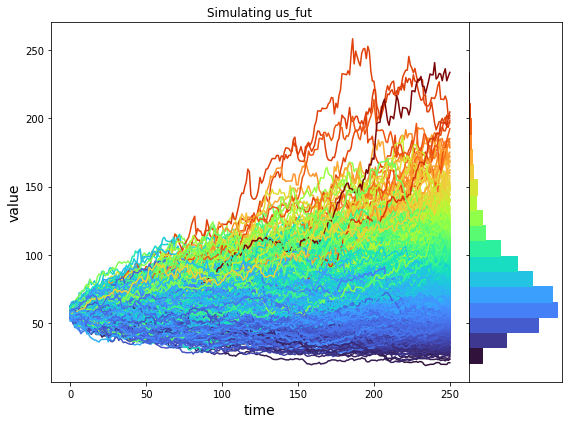

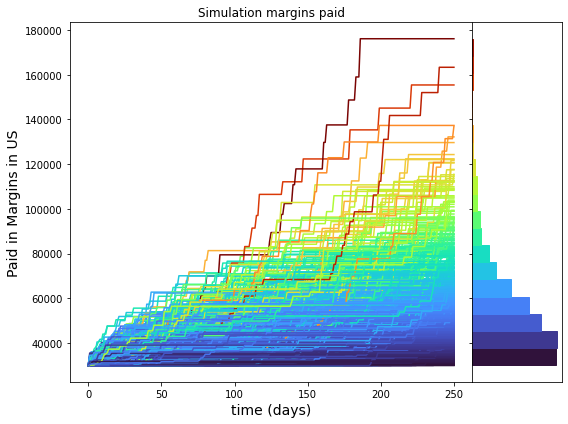

\begin{tabular}{lrr}
\toprule
{} &  electricity\_price\_squeeze &  margins\_squeeze \\
\midrule
mean   &                      76.74 &         53892.42 \\
std    &                      30.94 &         20346.83 \\
median &                      71.29 &         49226.61 \\
\bottomrule
\end{tabular}



In [110]:
fancy_plot(prices_us[:,255:], n = prices_us[:,255:].shape[0], time_steps= prices_us[:,255:].shape[1] - 1, display = 1000,
                title = f'Simulating {serie}', savefig= True, figdir= 'Figures/simulation_process_us_squeeze.pdf')

fancy_plot(tot_paid_us, n = tot_paid_us.shape[0], time_steps=tot_paid_us.shape[1] - 1, display = tot_paid_us.shape[0], xlabel = 'time (days)',
                 ylabel = 'Paid in Margins in US', savefig= True, figdir= 'Figures/simulation_margins_us_squeeze.pdf', title = 'Simulation margins paid')

data_garch_simulations = pd.DataFrame([prices_us[:,-1],tot_paid_us[:,-1]]).transpose()
data_garch_simulations = data_garch_simulations.rename(columns = {0: 'electricity_price', 1:'margins'})

stats_squeeze = data_garch_simulations.agg([ "mean","std", "median"])
stats_squeeze = stats_squeeze.rename(columns = {'electricity_price': 'electricity_price_squeeze' , 'margins':'margins_squeeze'})
print(stats_squeeze.apply(lambda x: np.round(x,2)).to_latex())

In [111]:
prices_us_squeeze = prices_us[:,-1]
margin_us_squeeze = tot_paid_us[:,-1]

$\LARGE \text{US in the non squeeze period}$

In [112]:
def sigma_formula(rs, lam):
    weights = np.array([lam ** i for i in range(1,len(rs)+ 1)])
    
    S =  (lam - (lam ** (len(rs)+1)))/(1 - lam)
    
    sigma_2 = (np.inner(( rs ** 2) , weights))/S
    
    return np.sqrt(sigma_2)

def risk_multiplier(rs, sigs, alpha = 0.95):
    q = np.quantile(rs / sigs, alpha)
    Q = np.quantile(rs / sigs, 1  - alpha)
    
    return 0.5 * (np.abs(q) + np.abs(Q))


lam = 0.99
ecc_window = 255
N = 251
M = 1000
crisis_idx = 410
serie = 'us_fut'

M0        = 30000
T         = 22500
num_hours = 730
V0        = data_garch[serie].values[-1] * num_hours
l = np.sqrt(30)

u    = results[serie][1]
h    = results[serie][2]
phi0 = results[serie][0][0]
phi  = results[serie][0][1]
df   = results[serie][0][-1]

returns = np.zeros([M, N + 2 * ecc_window])
prices_us  = np.zeros([M, N + 2 * ecc_window])
sigmas  = np.zeros([M, N + 2 * ecc_window])
margins = np.zeros([M, N + 1])

margins[:,0] = M0

first_returns = np.log(data_garch[serie]).diff().values[-(ecc_window * 2):]
first_prices_us  = data_garch[serie][-(ecc_window * 2 ):]

for i in range(M):
    returns[i,:2 * ecc_window] = first_returns
    prices_us[i ,:2 * ecc_window] = first_prices_us
    
    for time in range(ecc_window):
        sigmas[i ,ecc_window + time] = sigma_formula(returns[i, time : ecc_window + time ], lam)
        

returns = returns[:, ecc_window:]
prices_us  = prices_us[: , ecc_window:]
sigmas  = sigmas[: , ecc_window:]       
     
u_bis = residuals_AR(100 * np.diff(np.log(us_fut.values.flatten())),phi0, phi)
    
random_shocks = np.random.randint(len(u_bis) - crisis_idx, size=(M, N))
random_shocks = u_bis[random_shocks]

simulation_us = np.zeros([M,N + 1])
simulation_us[:,0] = np.log(data_garch[serie][-1] / data_garch[serie][-2]) * 100

Rs = []
Pts = []

for step in range(1,N+1):
    
    simulation_us[:,step] = (phi0 + np.inner(phi,simulation_us[:,step - 1].reshape((M,1))) + random_shocks[:, step - 1]) / 100
    returns[: ,ecc_window + step - 1] = simulation_us[:,step]
    prices_us[:,ecc_window + step - 1] = prices_us[:,ecc_window + step - 2] * np.exp(simulation_us[:,step])
    
    for m in range(M):
        sigmas[m,ecc_window + step - 1] = sigma_formula(returns[m, step - 1:ecc_window + step - 1], lam)
        
        R  = risk_multiplier(returns[m,step - 1: ecc_window + step - 1], sigmas[m,step - 1: ecc_window + step - 1])
        Pt = (num_hours * prices_us[m,ecc_window + step - 1]) - V0
        margins[m, step] = l * Pt * sigmas[m,ecc_window + step - 1] * R
        if m == 1:
            Pts.append(Pt)
            Rs.append(R)
            
margins = margins[:,1:]

In [113]:
position = 'short' ## short means selling electricity.

positive_margins = margins.copy()
positive_margins[positive_margins < 0] = 0
thersholds = positive_margins.copy() * 0.75

num_hours = 730
V0        = prices_us[:,254][0] * num_hours * np.ones(prices_us.shape[0])

paid_us = np.zeros_like(prices_us[:,255:])
paid_us[:,0] = M0

balance = np.zeros(positive_margins.shape[0])

for idx, price in enumerate(prices_us.transpose()[255:,:]):
    if idx == 0:
        continue
        
    V = price * num_hours
    
#     if position == 'long':
#         positive_margins[:, idx] = positive_margins[:, idx] + (V - V0)
        
    if position == 'short':
        balance = positive_margins[:, idx] - (V - V0)
    
    condition                 = balance < thersholds[:, idx]
    paid_us[:,idx][condition] = positive_margins[:,idx][condition] - balance[condition] 
    
#     if position == 'long':
#         V0 = V0 - paid_us[:,idx]
        
    if position == 'short':
        V0 = V0 + paid_us[:,idx]

tot_paid_us = np.cumsum(paid_us, axis=1)

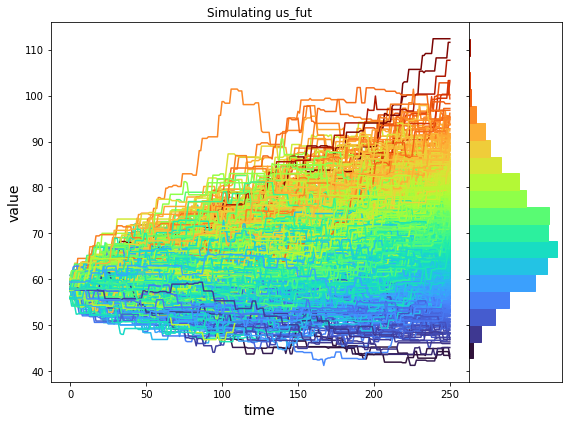

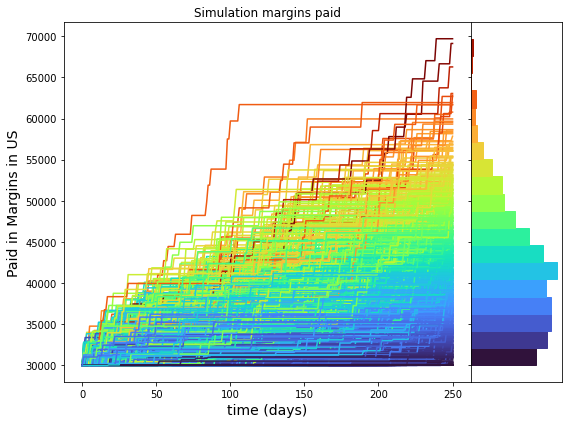

\begin{tabular}{lrr}
\toprule
{} &  electricity\_price\_non\_squeeze &  margins\_non\_squeeze \\
\midrule
mean   &                          69.91 &             41110.45 \\
std    &                          11.11 &              7169.56 \\
median &                          69.20 &             40379.46 \\
\bottomrule
\end{tabular}



In [114]:
fancy_plot(prices_us[:,255:], n = prices_us[:,255:].shape[0], time_steps= prices_us[:,255:].shape[1] - 1, display = 1000,
                title = f'Simulating {serie}', savefig= True, figdir= 'Figures/simulation_process_us_non_squeeze.pdf')

fancy_plot(tot_paid_us, n = tot_paid_us.shape[0], time_steps=tot_paid_us.shape[1] - 1, display = tot_paid_us.shape[0], xlabel = 'time (days)',
                 ylabel = 'Paid in Margins in US', savefig= True, figdir= 'Figures/simulation_margins_us_non_squeeze.pdf', title = 'Simulation margins paid')

data_garch_simulations = pd.DataFrame([prices_us[:,-1],tot_paid_us[:,-1]]).transpose()
data_garch_simulations = data_garch_simulations.rename(columns = {0: 'electricity_price', 1:'margins'})

stats_non_squeeze = data_garch_simulations.agg([ "mean","std", "median"])
stats_non_squeeze = stats_non_squeeze.rename(columns = {'electricity_price': 'electricity_price_non_squeeze' , 'margins':'margins_non_squeeze'})
print(stats_non_squeeze.apply(lambda x: np.round(x,2)).to_latex())

In [115]:
prices_us_non_squeeze = prices_us[:,-1]
margin_us_non_squeeze = tot_paid_us[:,-1]

In [116]:
print('means')
print(scipy.stats.ttest_ind(prices_us_squeeze, prices_us_non_squeeze)[1])
print(scipy.stats.ttest_ind(margin_us_squeeze, margin_us_non_squeeze)[1])

print('variance')
print(f_test(prices_us_squeeze, prices_us_non_squeeze)[1])
print(f_test(margin_us_squeeze, margin_us_non_squeeze)[1])

print('medians')
_ = test_median(prices_us_squeeze, prices_us_non_squeeze)
_ = test_median(margin_us_squeeze, margin_us_non_squeeze)

means
6.201177310435657e-11
2.7294479313744893e-72
variance
1.1102230246251565e-16
1.1102230246251565e-16
medians
0.0139
0.0


In [125]:
serie_prices_squeeze = prices_eu_squeeze - prices_us_squeeze
serie_prices_non_squeeze = prices_eu_non_squeeze - prices_us_non_squeeze
serie_margin_squeeze = margin_eu_squeeze - margin_us_squeeze
serie_margin_non_squeeze = margin_eu_non_squeeze - margin_us_non_squeeze


print('means')
print(scipy.stats.ttest_ind(serie_prices_squeeze, serie_prices_non_squeeze)[1])
print(scipy.stats.ttest_ind(serie_margin_squeeze, serie_margin_non_squeeze)[1])

print('variance')
print(f_test(serie_prices_squeeze, serie_prices_non_squeeze)[1])
print(f_test(serie_margin_squeeze, serie_margin_non_squeeze)[1])

print('medians')
_ = test_median(serie_prices_squeeze, serie_prices_non_squeeze)
_ = test_median(serie_margin_squeeze, serie_margin_non_squeeze)

means
8.90028880289708e-05
1.2079939032253236e-10
variance
1.1102230246251565e-16
1.1102230246251565e-16
medians
0.0
0.2225


In [90]:
stats = pd.merge(stats_squeeze, stats_non_squeeze, left_index=True, right_index=True)

stats['price_diff']  = stats['electricity_price_squeeze'] - stats['electricity_price_non_squeeze']
stats['margin_diff'] = stats['margins_squeeze'] - stats['margins_non_squeeze']

print(stats.apply(lambda x: np.round(x,2)).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  electricity\_price\_squeeze &  margins\_squeeze &  electricity\_price\_non\_squeeze &  margins\_non\_squeeze &  price\_diff &  margin\_diff \\
\midrule
mean   &                      76.74 &         53959.15 &                          69.67 &             40769.56 &        7.07 &     13189.59 \\
std    &                      31.23 &         20305.66 &                          10.63 &              6968.77 &       20.60 &     13336.89 \\
median &                      71.11 &         49270.22 &                          68.81 &             39660.33 &        2.30 &      9609.89 \\
\bottomrule
\end{tabular}



In [93]:
margins

array([[247.64869355, 248.2008483 , 727.00989019, ..., 709.42522723,
        799.40112723, 816.42660741],
       [-30.81775872, -30.88035237, -30.02695689, ..., 432.59721203,
        371.15204105, 367.42308146],
       [443.83077289, 445.00741073, 432.71777482, ..., 532.8607074 ,
        455.54130065, 451.83918183],
       ...,
       [-30.81775872, -30.88035237, -30.02695689, ..., 183.19357003,
        162.93329745, 161.48556646],
       [-30.81775872, -30.88035237, -30.02695689, ..., 221.68567767,
        205.06339618, 249.38060896],
       [-30.81775872,  30.34973877,  29.58201753, ...,  35.28235638,
         33.019206  ,  32.47420244]])

In [91]:
print((stats_eu - stats).apply(lambda x:np.round(x,2)).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  electricity\_price\_squeeze &  margins\_squeeze &  electricity\_price\_non\_squeeze &  margins\_non\_squeeze &  price\_diff &  margin\_diff \\
\midrule
mean   &                     311.88 &        296343.60 &                         343.52 &            173721.03 &      -31.63 &    122622.58 \\
std    &                     617.16 &        484469.46 &                         238.30 &            176297.51 &      378.87 &    308171.95 \\
median &                     115.96 &        143555.41 &                         282.33 &            121939.63 &     -166.36 &     21615.78 \\
\bottomrule
\end{tabular}



$\LARGE \text{Means plots}$

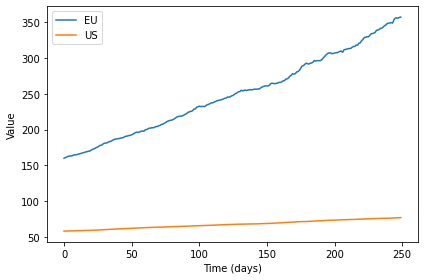

In [225]:
plt.plot(prices_eu.mean(axis = 0)[255:], label = 'EU')
plt.plot(prices_us.mean(axis = 0)[255:],label = 'US')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/avg_price_simulation.pdf')
plt.show()

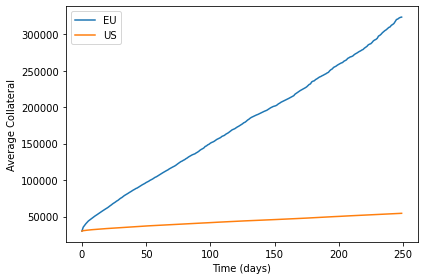

In [226]:
plt.plot(tot_paid_eu.mean(axis = 0), label = 'EU')
plt.plot(tot_paid_us.mean(axis = 0),label = 'US')
plt.xlabel('Time (days)')
plt.ylabel('Average Collateral')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/avg_margin_paid_simulation.pdf')
plt.show()

### Margins in the original time_series

In [28]:
with open('fitted_models_crisis.pickle', 'rb') as handle:
    results = pickle.load(handle)

def sigma_formula(rs, lam):
    weights = np.array([lam ** i for i in range(1,len(rs)+ 1)])
    
    S =  (lam - (lam ** (len(rs)+1)))/(1 - lam)
    
    sigma_2 = (np.inner((rs ** 2) , weights))/S
    
    return np.sqrt(sigma_2)

def risk_multiplier(rs, sigs, alpha = 0.95):
    q = np.quantile(rs / sigs, alpha)
    Q = np.quantile(rs / sigs, 1  - alpha)
    
    return 0.5 * (np.abs(q) + np.abs(Q))


################### data_eex_qt case ###################

serie = 'ger_fut_1m'
# serie = 'us_fut'


lam = 0.99
ecc_window = 255
N = 250
M = 10
crisis_idx = 410


M0        = 30000
T         = 22500
num_hours = 730
# V0        = data_eex_qt.sort_index().values[ecc_window][0] * num_hours #########
l = np.sqrt(30)

u    = results[serie][1]
h    = results[serie][2]
phi0 = results[serie][0][0]
phi  = results[serie][0][1]
df   = results[serie][0][-1]


# returns = np.log(data_garch.us_fut.sort_index()).diff().values[1:].flatten() ##########
# prices  = data_garch.us_fut.sort_index().values[1:].flatten()                       ##########
returns = np.log(data_garch.ger_fut_1m.sort_index()).diff().values[1:].flatten() ##########
prices  = data_garch.ger_fut_1m.sort_index().values[1:].flatten()                       ##########

sigmas  = np.zeros(len(prices) - ecc_window)
margins = np.zeros(len(prices) - 2 * ecc_window - 1)


for time in range(len(prices) - ecc_window):
    sigmas[time] = sigma_formula(returns[time : ecc_window + time ], lam)
        

returns = returns[ecc_window:]
prices  = prices[ecc_window:]      
    

Rs = []
Pts = []

for time in range(len(prices) - ecc_window - 1):
    
    R  = risk_multiplier(returns[time + 1: ecc_window + time + 1], sigmas[time: ecc_window + time])
#     Pt = (num_hours * prices[time]) - V0
    Pt = (num_hours * prices[time]) ## Settlement price
    
    margins[time] = l * Pt * sigmas[time + 1] * R
    
    Rs.append(R)
    Pts.append(Pt)
    
    
############### US CASE #############

# serie = 'eex_qt'
serie = 'us_fut_1m'


lam = 0.99
ecc_window = 255
N = 250
M = 10
crisis_idx = 410


M0        = 30000
T         = 22500
num_hours = 730
# V0        = data_eex_qt.sort_index().values[ecc_window][0] * num_hours #########
l = np.sqrt(30)

u    = results[serie][1]
h    = results[serie][2]
phi0 = results[serie][0][0]
phi  = results[serie][0][1]
df   = results[serie][0][-1]


returns = np.log(data_garch.us_fut_1m.sort_index()).diff().values[1:].flatten() ##########
prices  = data_garch.us_fut_1m.sort_index().values[1:].flatten()                       ##########
# returns = np.log(data_garch.eex_qt.sort_index()).diff().values[1:].flatten() ##########
# prices  = data_garch.eex_qt.sort_index().values[1:].flatten()                       ##########

sigmas  = np.zeros(len(prices) - ecc_window)
us_margins = np.zeros(len(prices) - 2 * ecc_window - 1)


for time in range(len(prices) - ecc_window):
    sigmas[time] = sigma_formula(returns[time : ecc_window + time ], lam)
        

returns = returns[ecc_window:]
prices  = prices[ecc_window:]      
    

Rs = []
Pts = []

for time in range(len(prices) - ecc_window - 1):
    
    R  = risk_multiplier(returns[time + 1: ecc_window + time + 1], sigmas[time: ecc_window + time])
#     Pt = (num_hours * prices[time]) - V0
    Pt = (num_hours * prices[time]) ## Settlement price
    
    us_margins[time] = l * Pt * sigmas[time + 1] * R
    
    Rs.append(R)
    Pts.append(Pt)

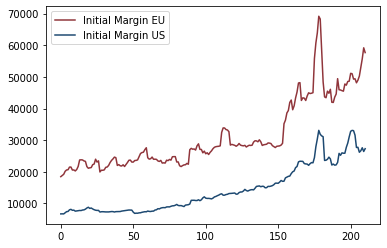

In [37]:
colors = ['#90353b', '#1d4971', 'green']
plt.plot(margins, label = 'Initial Margin EU', color = colors[0])
plt.plot(us_margins * all_data['ger_1d'][-ecc_window]/all_data['Was_1d'][-ecc_window], label = 'Initial Margin US', color = colors[1])
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
#           ncol=3, fancybox=True, shadow=True)
plt.legend()
plt.savefig('Figures/risk_and_margin.pdf')
plt.show()

In [23]:
data_garch.eex_qt

Datetime
2020-01-03     40.943316
2020-01-06     40.294676
2020-01-07     40.212000
2020-01-08     40.056666
2020-01-09     40.218708
                 ...    
2023-01-30    150.884937
2023-01-31    159.711372
2023-02-01    163.609310
2023-02-02    158.287722
2023-02-03    158.647764
Name: eex_qt, Length: 769, dtype: float64

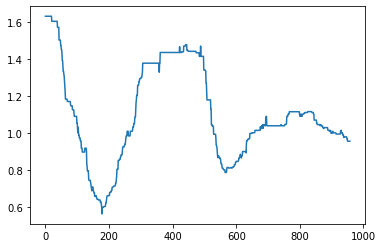

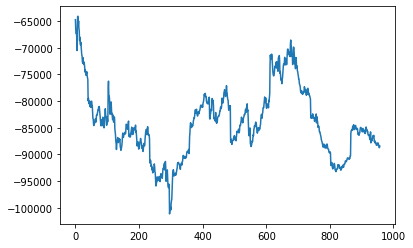

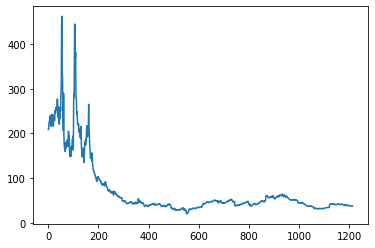

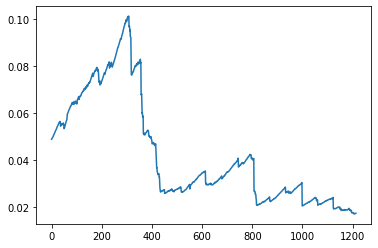

In [88]:
plt.plot(Rs)
plt.show()
plt.plot(Pts)
plt.show()
plt.plot(prices)
plt.show()
plt.plot(sigmas)
plt.show()

In [50]:
df = pd.merge(pd.DataFrame(data_garch['eex_qt']), df_margins, left_index=True, right_index=True).iloc[1:,:]

In [51]:
df

eex_qt       Margins
2020-01-03   40.943316   6822.741867
2020-01-06   40.294676   5941.663741
2020-01-07   40.212000   4172.930523
2020-01-08   40.056666   4104.097348
2020-01-09   40.218708   4125.206668
...                ...           ...
2023-01-30  150.884937  45782.262304
2023-01-31  159.711372  48415.114919
2023-02-01  163.609310  47955.435240
2023-02-02  158.287722  50152.947497
2023-02-03  158.647764  48228.168777

[769 rows x 2 columns]

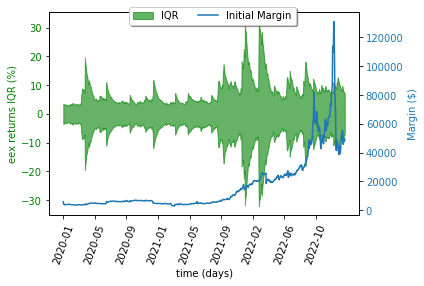

In [8]:
date_f = pd.to_datetime(pd.DataFrame(data_garch.index.values,columns=['col1']).col1).dt.to_period('m')

index = data_eex_qt.sort_index().index.values[255 + 255 + 2:]
df_margins = pd.DataFrame(margins, columns = ['Margins'])
df_margins = df_margins.set_index(index)
df_margins = pd.merge(pd.DataFrame(data_garch['eex_qt']), df_margins, left_index=True, right_index=True).iloc[1:,:]

u = results[serie][1]
h = results[serie][2]
df = results[serie][0][-1]
x = range(len(h))
# plt.figure(figsize=(10,6))
# if serie == 'us_fut':
#     plt.xticks(x, date_f[1+500:], rotation = 70)
# else:
#     plt.xticks(x, date_f[1:], rotation = 70)
# plt.locator_params(axis='x', nbins=9)

fig, ax1 = plt.subplots()
plt.xticks(x, date_f[1:], rotation = 70)
plt.locator_params(axis='x', nbins=9)

top = t.ppf(0.95, df = df, scale = np.sqrt(h) )
bot = t.ppf(0.05, df = df, scale = np.sqrt(h) )

color = 'green'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('eex returns IQR (%)', color=color)
ax1.fill_between(x, top, bot, where= top >= bot, color='green', interpolate=True, alpha = 0.6, label = 'IQR')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Margin ($)', color=color)  # we already handled the x-label with ax1
ax2.plot(x, df_margins['Margins'].values, color=color, label = 'Initial Margin')
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=3, fancybox=True, shadow=True)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('Figures/risk_and_margin.pdf')
plt.show()



# plt.plot(x, np.sqrt(h) * eps_vol(df))



# plt.title(serie)
# plt.fill_between(x, top, bot, where= top >= bot, color='green', interpolate=True, alpha = 0.6, label = 'IQR')
# #     plt.axvline(x = 595, color = 'orange', linestyle="--", label = 'Covid')
# if serie != 'us_fut':
#     plt.axvline(x = 410, color = 'red', linestyle="--", label = 'Gas Crisis')
# plt.axhline(color = 'black')
# plt.ylim(-20,20)
# plt.legend()
# plt.show()

In [38]:
index = data_eex_qt.sort_index().index.values[255 + 255 + 2:]
df_margins = pd.DataFrame(margins, columns = ['Margins'])
df_margins = df_margins.set_index(index)

In [39]:
df_margins

Margins
2019-08-23   5667.017868
2019-08-26   5772.571337
2019-08-27   5842.428825
2019-08-28   5917.857335
2019-08-29   5963.178541
...                  ...
2023-05-17  67050.483936
2023-05-18  65780.912536
2023-05-19  65014.881198
2023-05-22  62695.670234
2023-05-23  62681.647622

[958 rows x 1 columns]

eex_qt       Margins
2020-01-03   40.943316   6822.741867
2020-01-06   40.294676   5941.663741
2020-01-07   40.212000   4172.930523
2020-01-08   40.056666   4104.097348
2020-01-09   40.218708   4125.206668
...                ...           ...
2023-01-30  150.884937  45782.262304
2023-01-31  159.711372  48415.114919
2023-02-01  163.609310  47955.435240
2023-02-02  158.287722  50152.947497
2023-02-03  158.647764  48228.168777

[769 rows x 2 columns]

In [31]:
data_garch['eex_qt']

Datetime
2020-01-03     40.943316
2020-01-06     40.294676
2020-01-07     40.212000
2020-01-08     40.056666
2020-01-09     40.218708
                 ...    
2023-01-30    150.884937
2023-01-31    159.711372
2023-02-01    163.609310
2023-02-02    158.287722
2023-02-03    158.647764
Name: eex_qt, Length: 769, dtype: float64

Margins
2019-08-23   5667.017868
2019-08-26   5772.571337
2019-08-27   5842.428825
2019-08-28   5917.857335
2019-08-29   5963.178541
...                  ...
2023-05-17  67050.483936
2023-05-18  65780.912536
2023-05-19  65014.881198
2023-05-22  62695.670234
2023-05-23  62681.647622

[958 rows x 1 columns]

In [79]:
ecc_window + time + 1

514

In [78]:
len(returns)

513

In [76]:
time

258

In [74]:
len(returns[time + 1: ecc_window + time + 1])a

255

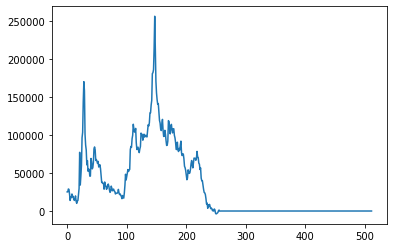

In [77]:
plt.plot(margins)

Maximum likelihood estimates:
0.2349 [-0.3939] 0.3241 [0.0548] [0.8713] 3.1187



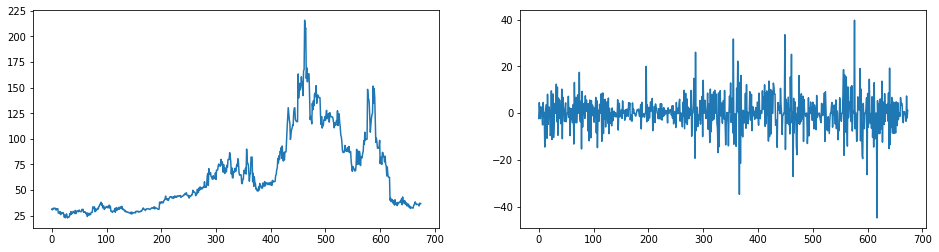

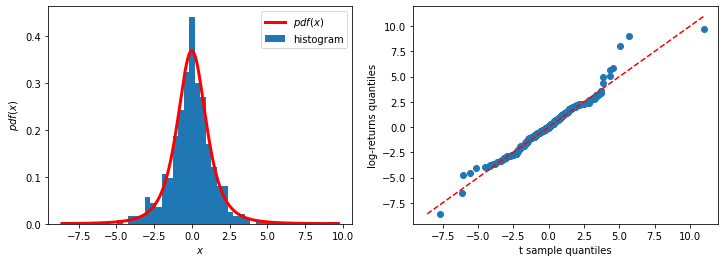

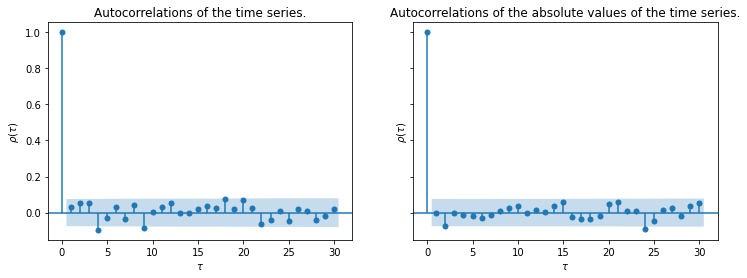

In [165]:
prices = data['Index1'].values[700:]

phi_0, phi= 0.2, [0.1]
theta = []
kappa = 0.1
alpha = [0.05]
beta = [0.90]
p = len(phi)
q = len(theta)
r = len(alpha) 
s = len(beta)
delay = max(p, q, r, s)
nu = 5

params, u, h = arma_garch_t_noise(phi_0, phi, theta, kappa, alpha, beta, nu)

In [32]:
t.ppf(0.95, df = 1.9)

3.0275397493595047

In [36]:
norm.ppf(0.975, scale = 2)

3.919927969080108

In [39]:
results['Index1'][0][-1]

2.271764650813263

In [50]:
u = results['Index1'][1]
h = results['Index1'][2]

In [85]:
date_f[2650]

Period('2022-03', 'M')